### Data needed to run this code can be found on the Sequence Read Archive under BioProject PRJNA643848

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
from collections import defaultdict
import pandas as pd
import math
import matplotlib.patches as patch
import pysam
import os
import csv
import re
from termcolor import cprint
import xlsxwriter
import numpy as np
from scipy.stats import binom_test
import logomaker
import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
blue = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
red = (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)
green = (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)
purple = (0.5058823529411764, 0.4470588235294118, 0.6980392156862745)
gold = (0.8, 0.7254901960784313, 0.4549019607843137)
cyan = (0.39215686274509803, 0.7098039215686275, 0.803921568627451)

index = [0, 1, 2, 3]
index2 = ['A', 'C', 'G', 'T']
data_dir = '../../data/'
figurePrint_dir = '/Users/jelacqua/Desktop/'
printFigures = False

plt.rcParams['axes.prop_cycle'] = plt.cycler(color = [blue, green, red, purple])
sns.set(context = "paper", style = "white")
sns.set_context("paper", rc = {"lines.linewidth": 2, 'axes.labelsize': 8, 'text.fontsize': 8, 'legend.fontsize': 8,
            'xtick.labelsize': 8, 'ytick.labelsize': 8, 'text.usetex': False})

### Figure 2

In [3]:
def readFastq(fileName):
    readNames = []
    readBases = []
    readQualities = []
    with gzip.open(fileName) as file:
        text = file.readlines()
        for i in range(0, len(text), 4):
            readNames.append(text[i][:-1])
            readBases.append(text[i + 1][:-1])
            readQualities.append(text[i + 2][:-1])
    return readNames, readBases, readQualities

def reverseComplement(seq):
    #Return reverse complement of DNA sequence input as a string
    if type(seq) == str:
        return seq.replace('G', 'X').replace('C', 'G').replace('X', 'C').replace('A', 'X').replace('T', 'A').replace('X', 'T')[::-1]
    else:
        return seq.replace(b'G', b'X').replace(b'C', b'G').replace(b'X', b'C').replace(b'A', b'X').replace(b'T', b'A').replace(b'X', b'T')[::-1]

def baseTransitions(seq):
    #Returen sequence as a string with A/G replacing one another and C/T replacing one another
    return seq.replace('G', 'X').replace('A', 'G').replace('X', 'A').replace('C', 'X').replace('T', 'C').replace('X', 'T')

# determines if a library read is valid based on correct identification of at least 1 of 2 pre-chosen 3 nucleotide sequences
# also only keep base calls with high quality score
def processRead(seq, qual, startIndex, length, rc = False, qcutoff = 30):
    # seqs is currently a tuple with a single element (a string), extract the string
    if rc:
        seq = reverseComplement(seq)

    # lib is the sequence of 'length' bases around the nick
    read = list(seq[startIndex:startIndex + length].decode('ascii'))

    # only keep reads with high quality score
    q = list(qual[startIndex:startIndex + length])
    for i in range(len(q)):
        if q[i] - 33 < qcutoff:
            read[i] == 'N'

    # valid is a quality control check
    # don't use the current sequence if neither of these sets of 3 nucleotides is correct
    valid = seq[startIndex - 8:startIndex - 5] == b'CCA' or seq[startIndex - 5:startIndex - 2] == b'AGG'

    return ''.join(read), valid

def countOligoBases(files, startIndex = 28, length = 13, rc = False):
    bases = []
    for file in files:
        counter = 0
        library = defaultdict(str)
        _, seqs, quals = readFastq(file)
        for i in range(len(seqs)):
            seqs[i], qc = processRead(seqs[i], quals[i], startIndex, length, rc)
            # if current sequence passed quality control check
            if qc:
                # add current sequence (only 'length' nucleotides around the nick) to the library
                library[counter] = [j for j in seqs[i]]
                counter += 1

        temp = pd.DataFrame.from_dict(library, orient = 'index')
        ini = pd.DataFrame(temp[0].value_counts())

        # for each position in the library, ini stores the number of times each nucleotide occurred
        for item in range(1, temp.shape[1]):
            ini = pd.concat([ini, pd.DataFrame(temp[item].value_counts())], axis = 1)
        ini.loc['N'] = 0
        temp = ini / ini.sum(axis = 0)[0]
        bases.append(temp.fillna(0))
    return bases

In [4]:
taq = countOligoBases([data_dir + 'fig2/oligo_dPTP_dKTP_taqPCR_nickAt' + i + '_R2.fastq.gz' for i in 'GTCA'])
kapa = countOligoBases([data_dir + 'fig2/oligo_dPTP_dKTP_kapaPCR_nickAt' + i + '_R2.fastq.gz' for i in 'GTCA'])
seq = 'TGAGTCACTTGCG'

In [5]:
def plotOligo(bases, title = [], figsize = [3.373, 5.656]):
    # plot histograms of base occurrence at each position
    plt.figure(figsize = figsize)
    for i in range(1, len(bases) + 1):
        for sample in range(1, len(bases[i - 1]) + 1):
            ax = plt.subplot(len(bases[i - 1]), len(bases), (sample - 1) * len(bases) + i)
            ax.grid(False)
            plt.ylim([0, 1.05])
            ini = bases[i - 1][sample - 1]
            p1 = plt.bar(ini.columns, ini.loc['A'], edgecolor = blue, label = 'A')
            p2 = plt.bar(ini.columns, ini.loc['C'], bottom = ini.loc['A'], edgecolor = green, label = 'C')
            p3 = plt.bar(ini.columns, ini.loc['T'], bottom = ini.loc['A'] + ini.loc['C'], edgecolor = red, label = 'T')
            p4 = plt.bar(ini.columns, ini.loc['G'], bottom = ini.loc['A'] + ini.loc['C'] + ini.loc['T'], edgecolor = purple, label='G')
            if i == 1:
                plt.ylabel('Fraction of reads')
                plt.yticks([0, 0.25, 0.5, 0.75, 1])
            else:
                plt.yticks([])
            if i == len(bases) and sample == 1:
                ax.legend(loc = "upper left", bbox_to_anchor = (1, 1))
            if sample == 1 and title:
                plt.title(title[i - 1], fontsize = 8)
            if sample == len(bases[i - 1]):
                plt.xlabel('Base position / Expected base')
                plt.xticks(ini.columns, [str(j - 3) + '\n' + seq[j] for j in ini.columns])
            else:
                plt.xticks([])
    sns.despine()

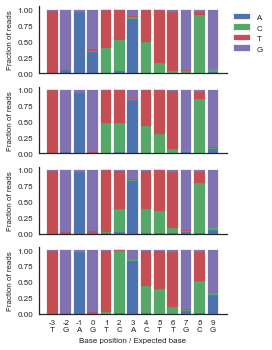

In [6]:
plotOligo([taq])
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_2B.pdf', bbox_inches = 'tight', transparent = 'True')

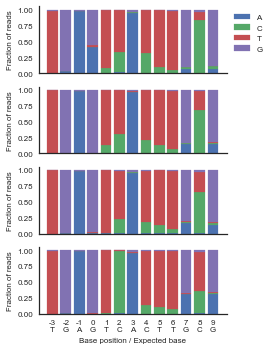

In [7]:
plotOligo([kapa])
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_2C.pdf', bbox_inches = 'tight', transparent = 'True')

### Figure 3

In [8]:
def plotCircle(length, topNicks = [], topColors = [], topOffsets = [], bottomNicks = [], bottomColors = [], bottomOffsets = [], fontsize = 18):
    plt.axes()

    circle = plt.Circle((0, 0), radius = 2, fc = 'k')
    plt.gca().add_patch(circle)
    circle = plt.Circle((0, 0), radius = 1.9, fc = 'w')
    plt.gca().add_patch(circle)
    circle = plt.Circle((0, 0), radius = 1.8, fc = 'k')
    plt.gca().add_patch(circle)
    circle = plt.Circle((0, 0), radius = 1.7, fc = 'w')
    plt.gca().add_patch(circle)

    t = 0.35

    plt.text(0, 0, format(length, ',') + ' bp', horizontalalignment = 'center', verticalalignment = 'center', fontsize = fontsize)

    i = 0
    for nick in topNicks:
        angle = math.pi * (0.5 - 2 * nick / length)
        if topOffsets and topOffsets[i]:
            locs = (((2 + t * 0.75 ** 0.5) * math.cos(angle), (2 + t * 0.75 ** 0.5) * math.sin(angle)), \
                    ((2 + t * 3 ** 0.5) * math.cos(angle) - (t / 2) * math.cos(math.pi / 2 - angle), (2 + t * 3 ** 0.5) * math.sin(angle) + (t / 2) * math.sin(math.pi / 2 - angle)), \
                    ((2 + t * 3 ** 0.5) * math.cos(angle) + (t / 2) * math.cos(math.pi / 2 - angle), (2 + t * 3 ** 0.5) * math.sin(angle) - (t / 2) * math.sin(math.pi / 2 - angle)))
        else:
            locs = ((2 * math.cos(angle), 2 * math.sin(angle)), \
                    ((2 + t * 0.75 ** 0.5) * math.cos(angle) - (t / 2) * math.cos(math.pi / 2 - angle), (2 + t * 0.75 ** 0.5) * math.sin(angle) + (t / 2) * math.sin(math.pi / 2 - angle)), \
                    ((2 + t * 0.75 ** 0.5) * math.cos(angle) + (t / 2) * math.cos(math.pi / 2 - angle), (2 + t * 0.75 ** 0.5) * math.sin(angle) - (t / 2) * math.sin(math.pi / 2 - angle)))
        if len(topColors) == 1:
            triangle = patch.Polygon(locs, clip_on = False, color = topColors[0])
        else:
            triangle = patch.Polygon(locs, clip_on = False, color = topColors[i])
        plt.gca().add_patch(triangle)
        i += 1
        
    i = 0
    for nick in bottomNicks:
        angle = math.pi * (0.5 - 2 * nick / length)
        if bottomOffsets and bottomOffsets[i]:
            locs = (((1.7 - t * 0.75 ** 0.5) * math.cos(angle), (1.7 - t * 0.75 ** 0.5) * math.sin(angle)), \
                    ((1.7 - t * 3 ** 0.5) * math.cos(angle) - (t / 2) * math.cos(math.pi / 2 - angle), (1.7 - t * 3 ** 0.5) * math.sin(angle) + (t / 2) * math.sin(math.pi / 2 - angle)), \
                    ((1.7 - t * 3 ** 0.5) * math.cos(angle) + (t / 2) * math.cos(math.pi / 2 - angle), (1.7 - t * 3 ** 0.5) * math.sin(angle) - (t / 2) * math.sin(math.pi / 2 - angle)))
        else:
            locs = ((1.7 * math.cos(angle), 1.7 * math.sin(angle)), \
                    ((1.7 - t * 0.75 ** 0.5) * math.cos(angle) - (t / 2) * math.cos(math.pi / 2 - angle), (1.7 - t * 0.75 ** 0.5) * math.sin(angle) + (t / 2) * math.sin(math.pi / 2 - angle)), \
                    ((1.7 - t * 0.75 ** 0.5) * math.cos(angle) + (t / 2) * math.cos(math.pi / 2 - angle), (1.7 - t * 0.75 ** 0.5) * math.sin(angle) - (t / 2) * math.sin(math.pi / 2 - angle)))
        if len(bottomColors) == 1:
            triangle = patch.Polygon(locs, clip_on = False, color = bottomColors[0])
        else:
            triangle = patch.Polygon(locs, clip_on = False, color = bottomColors[i])
        plt.gca().add_patch(triangle)
        i += 1

    plt.axis('scaled')
    plt.axis('off')

In [9]:
def countBaseFrequency(file, chromosome):
    samfile = pysam.AlignmentFile(file)
    c = samfile.count_coverage(chromosome, quality_threshold = 30)

    samfile.close()
    
    cov = pd.DataFrame()
    for i in index:
        cov = pd.concat([cov, pd.DataFrame(c[i].tolist()).T])
    cov.index = index2
    readCount = cov.sum(axis = 0)
    
    return [cov / cov.sum(axis = 0), readCount]

def countCoverage(file, construct = None, mapQFilter = 0):
    samfile = pysam.AlignmentFile(file)
    header = str(samfile.header)
    if construct is None:
        ln = header.index('LN:') + 3
        loopThrough = samfile
    else:
        ln = header.index('LN:', header.index(construct)) + 3
        loopThrough = samfile.fetch(construct)
    ln = int(header[ln:header.index('\n', ln)])
    cov = np.array([0] * ln)
    for read in loopThrough:
        if read.is_proper_pair and read.mapping_quality >= mapQFilter:
            start = read.reference_start
            mateStart = read.next_reference_start
            if start > mateStart or (start == mateStart and read.mate_is_reverse):
                cov[mateStart:read.reference_end] += 1
    samfile.close()
    return cov

def getData(file, chromosome, ext = ['.sorted.bam', '.noDup.bam']):
    return countBaseFrequency(file + ext[0], chromosome), countCoverage(file + ext[1])

def readReference(file, chromosome = ''):
    if file[-6:] == '.fasta' or file[-3:] == '.fa':
        with open(file) as textfile:
            tempRef = textfile.readlines()
        indices = [i for i in range(len(tempRef)) if '>' in tempRef[i]]
        if len(indices) == 1:
            return ''.join(tempRef[1:]).replace('\n', '').upper()
        else:
            reference = dict()
            for i in range(len(indices) - 1):
                reference[tempRef[indices[i]][1:-1]] = ''.join(tempRef[indices[i] + 1:indices[i + 1]]).replace('\n', '')
            reference[tempRef[indices[-1]][1:-1]] = ''.join(tempRef[indices[-1] + 1:]).replace('\n', '')
            return reference
    else:
        reference = dict()
        for f in os.listdir(file):
            with open(file + '/' + f) as textfile:
                temp = textfile.readlines()
                reference[f[:f.rfind('.')]] = ''.join(temp).replace('\n', '')[len(f) - 2:]
        return reference

def hammingDistance(seq1, seq2):
    if len(seq1) != len(seq2):
        raise Exception('Sequences must be the same length.')
    dist = 0
    for i in range(len(seq1)):
        if seq1[i] != seq2[i] and seq1[i] != 'N' and seq2[i] != 'N':
            dist = dist + 1
    return dist

def loadPeaks(file = data_dir + 'fig5/Ecoli_genome_peaks.xls', skip = 23):
    peaks = dict()
    peaks['chromosome'] = []
    peaks['start'] = []
    peaks['end'] = []
    peaks['logP'] = []
    peaks['logQ'] = []
    peaks['pileup'] = []
    peaks['enrichment'] = []
    with open(file) as csvfile:
        reader = csv.reader(csvfile)
        for i in range(skip):
            next(reader)
        for row in reader:
            text = row[0].split('\t')
            peaks['chromosome'].append(text[0])
            peaks['start'].append(int(text[1]))
            peaks['end'].append(int(text[2]))
            peaks['logP'].append(float(text[6]))
            peaks['logQ'].append(float(text[8]))
            peaks['pileup'].append(int(round(float(text[5]))))
            peaks['enrichment'].append(float(text[7]))
    return pd.DataFrame(peaks)

In [10]:
controlBases, controlCov = getData(data_dir + 'fig3/plasmid_noNicks', 'plasmid_pilon')
controlBases = controlBases[0]
expBases, expCov = getData(data_dir + 'fig3/plasmid_NbBsmI', 'plasmid_pilon')
expBases = expBases[0]

plasmidReference = readReference(data_dir + 'fig3/pilon_psrM01.fasta', 'plasmid_pilon')
p = [i in 'CT' for i in plasmidReference]
k = [i in 'AG' for i in plasmidReference]

ontargets = []
for match in re.finditer('GAATGC', plasmidReference):
    ontargets.append(match.start() + 4.5)
for match in re.finditer(reverseComplement('GAATGC'), plasmidReference):
    ontargets.append(match.start() + 0.5)

# os.system('macs2 callpeak -t ' + data_dir + 'fig3/plasmid_NbBsmI.sorted.bam -g 7305 --nomodel -n ' + data_dir + 'fig3/plasmid_NbBsmI')
plasmidPeaks = loadPeaks(data_dir + 'fig3/plasmid_NbBsmI_peaks.xls')
peakBounds = sorted(list(plasmidPeaks.start) + list(plasmidPeaks.end))

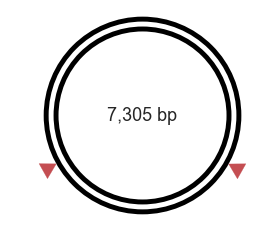

In [11]:
plotCircle(len(plasmidReference), ontargets, [red])
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_3A.pdf', bbox_inches = 'tight', transparent = 'True')

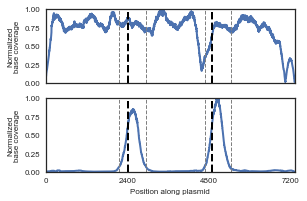

In [12]:
plt.figure(figsize = (4.462, 3))

cov = [controlCov, expCov]

for i in range(2):
    plt.subplot(2, 1, i + 1)
    plt.plot(range(len(cov[i])), cov[i] / max(cov[i]))
    plt.ylim((0, 1))
    plt.xlim((0, len(cov[i])))
    plt.yticks([0, 0.25, 0.5, 0.75, 1])
    if i == 0:
        plt.xticks([])
        plt.xlabel('')
    else:
        plt.xticks([0, 2400, 4800, 7200])
        plt.xlabel('Position along plasmid')
    plt.ylabel('Normalized\nbase coverage')

    for i in ontargets:
        plt.axvline(i, ls = 'dashed', color = 'black')

    for i in peakBounds:
        plt.axvline(i, ls = 'dashed', color = 'gray', lw = 1)
    
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_3B.pdf', bbox_inches = 'tight', transparent = 'True')

In [13]:
def plotPlasmidTransitions(loci, nick, xticks, xlab = True):
    plt.figure(figsize = (3.538, 1.8))
    
    transition = baseTransitions(plasmidReference)
    y = [expBases[i][transition[i]] for i in range(loci[0], loci[1] + 1)]
    yControl = [controlBases[i][transition[i]] for i in range(loci[0], loci[1] + 1)]
    
    plt.scatter([i for i in range(loci[0], loci[1] + 1) if p[i]], [y[i] for i in range(len(y)) if p[i + loci[0]]])
    plt.scatter([i for i in range(loci[0], loci[1] + 1) if k[i]], [y[i] for i in range(len(y)) if k[i + loci[0]]])
    plt.scatter(range(loci[0], loci[1] + 1), yControl, c = 'gray', s = 10)

    plt.xlim([loci[0] - 0.5, loci[1] + 0.5])
    plt.ylim([-0.02, 0.35])
    plt.yticks([0, 0.1, 0.2, 0.3])
    plt.xticks(xticks)
    if xlab:
        plt.xlabel('Position along plasmid')
    plt.ylabel('Base call\ntransition error rate')

    plt.axvline(nick, ls = 'dashed', color = 'black', lw = 1)

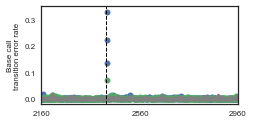

In [14]:
plotPlasmidTransitions(peakBounds[:2], ontargets[0], range(2160, 2961, 400), False)
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_3C_top.pdf', bbox_inches = 'tight', transparent = 'True')

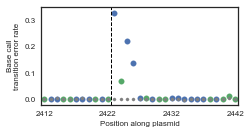

In [15]:
plotPlasmidTransitions([int(ontargets[0] - 10.5), int(ontargets[0] + 19.5)], ontargets[0], range(2412, 2443, 10))
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_3C_bottom.pdf', bbox_inches = 'tight', transparent = 'True')

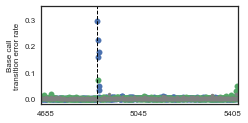

In [16]:
plotPlasmidTransitions(peakBounds[2:], ontargets[1], range(4685, 5406, 360), False)
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_3D_top.pdf', bbox_inches = 'tight', transparent = 'True')

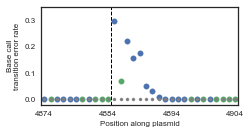

In [17]:
plotPlasmidTransitions([int(ontargets[1] - 10.5), int(ontargets[1] + 19.5)], ontargets[1], range(4874, 4905, 10))
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_3D_bottom.pdf', bbox_inches = 'tight', transparent = 'True')

### Figure 4

In [18]:
plasmidReference = readReference(data_dir + 'fig3/pilon_psrM01.fasta', 'plasmid_pilon')

plasmidOffBases, plasmidOffCov = getData(data_dir + 'fig4/plasmid_NbBsmI_withOfftargets', 'plasmid_pilon')
plasmidOffBases = pd.concat([plasmidOffBases[0].iloc[:, 7305:10956], plasmidOffBases[0].iloc[:, 3651:7305]], axis = 1)
plasmidOffBases.columns = range(7305)
plasmidOffCov = np.concatenate([plasmidOffCov[7305:10956], plasmidOffCov[3651:7305]])

# os.system('macs2 callpeak -t ' + data_dir + 'fig4/plasmid_NbBsmI_withOfftargets.sorted.bam -f BAMPE -q 0.95 -g 7305 --nomodel -n ' + data_dir + 'fig4/plasmid_NbBsmI_withOfftargets')
plasmidPeaks2 = loadPeaks(data_dir + 'fig4/plasmid_NbBsmI_withOfftargets_peaks.xls')
peakBounds2 = []
peakBounds2.append(plasmidPeaks2.start[2] - 7305)
peakBounds2.append(plasmidPeaks2.end[2] - 7305)
peakBounds2.append(plasmidPeaks2.start[1])
peakBounds2.append(plasmidPeaks2.end[1])
peakQ2 = list(plasmidPeaks2.logQ[2:0:-1])

locs1 = []
locs2 = []
for i in range(len(plasmidReference) - 7):
    if hammingDistance(plasmidReference[i:i + 7], 'NGCATTC') < 2:
        locs1.append(i + 1)
    elif hammingDistance(plasmidReference[i:i + 7], 'GAATGCN') < 2:
        locs2.append(i + 4)

transition = baseTransitions(plasmidReference)
pk = [plasmidOffBases[i].loc[transition[i]] / plasmidOffBases[i].loc[plasmidReference[i]] for i in range(len(plasmidReference))]

topNicks = [-100]
topNicks2 = [-100]
bottomNicks = []
bottomNicks2 = []
erroneousNickCalls = []
for i in range(len(plasmidReference)):
    if pk[i] > 0.012:
        if i in [1 + j for j in locs1]:
            topNicks.append(i - 1)
        elif i in locs2:
            bottomNicks.append(i)
        else:
            if i == topNicks[-1] + 2 or i == topNicks2[-1] + 2:
                topNicks2.append(i - 1)
            elif any([i in range(j - 3, j) for j in locs2]):
                bottomNicks2.append(i)
            else:
                erroneousNickCalls.append(i)
del topNicks[0]
del topNicks2[0]
assert not erroneousNickCalls

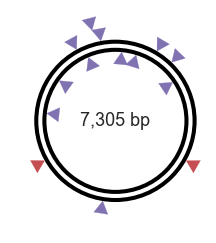

In [19]:
plotCircle(len(plasmidReference), topNicks = topNicks, topColors = [red if i in [2422, 4884] else purple for i in topNicks], topOffsets = [i == 7011 for i in topNicks], bottomNicks = bottomNicks, bottomColors = [purple])
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_4A.pdf', bbox_inches = 'tight', transparent = 'True')

In [20]:
def plotPlasmidOffTargets(bases, cov, onTargets, topOffTargets = [], bottomOffTargets = [], macs2Peaks = [], reference = [], plotBaseCallsOnlyInPeaks = False):
    fig = plt.figure(figsize = (3.468, 5.005))

    if plotBaseCallsOnlyInPeaks:
        grid = plt.GridSpec(2, 2)
        plt.subplot(grid[0, :])
        plt.xticks(range(0, len(cov), round(len(cov) - 100, -2) // 3))
    else:
        plt.subplot(2, 1, 1)
        plt.xticks([])
    plt.plot(range(len(cov)), cov / max(cov))
    plt.ylim((0, 1))
    plt.xlim((0, len(cov)))
    plt.yticks([0, 0.25, 0.5, 0.75, 1])
    plt.ylabel('Normalized base coverage')

    for i in topOffTargets:
        plt.axvline(i, c = purple, ls = 'dashed', ymin = 0, linewidth = 1)
    for i in bottomOffTargets:
        plt.axvline(i, c = cyan, ls = 'dashed', ymin = 0, linewidth = 1)
    for i in onTargets:
        plt.axvline(i, c = 'k', ls = 'dashed', ymin = 0, linewidth = 1)
    for i in macs2Peaks:
        plt.axvline(i, c = 'gray', ls = 'dashed', ymin = 0, linewidth = 1)

    transition = baseTransitions(reference)
    if plotBaseCallsOnlyInPeaks:
        plt.subplot(grid[1, 0])
        plt.scatter(range(macs2Peaks[0], macs2Peaks[1] + 1), [bases[i][transition[i]] for i in range(macs2Peaks[0], macs2Peaks[1] + 1)], s = 24)
        plt.ylim((0, 0.5))
        plt.xlim((macs2Peaks[0], macs2Peaks[1]))
        plt.xticks([macs2Peaks[0], macs2Peaks[1]])
        plt.yticks([0, 0.25, 0.5])
        plt.ylabel('Base call\ntransition error rate')
        for i in topOffTargets:
            if i >= macs2Peaks[0] and i < macs2Peaks[1]:
                plt.axvline(i, c = purple, ls = 'dashed', ymin = 0, linewidth = 1)
        for i in bottomOffTargets:
            if i >= macs2Peaks[0] and i < macs2Peaks[1]:
                plt.axvline(i, c = cyan, ls = 'dashed', ymin = 0, linewidth = 1)
        for i in onTargets:
            if i >= macs2Peaks[0] and i < macs2Peaks[1]:
                plt.axvline(i, c = 'k', ls = 'dashed', ymin = 0, linewidth = 1)
        
        plt.subplot(grid[1, 1])
        plt.scatter(range(macs2Peaks[2], macs2Peaks[3] + 1), [bases[i][transition[i]] for i in range(macs2Peaks[2], macs2Peaks[3] + 1)], s = 24)
        plt.ylim((0, 0.5))
        plt.xlim((macs2Peaks[2], macs2Peaks[3]))
        plt.yticks([])
        plt.xticks([macs2Peaks[2], macs2Peaks[3]])
        for i in topOffTargets:
            if i >= macs2Peaks[2] and i < macs2Peaks[3]:
                plt.axvline(i, c = purple, ls = 'dashed', ymin = 0, linewidth = 1)
        for i in bottomOffTargets:
            if i >= macs2Peaks[2] and i < macs2Peaks[3]:
                plt.axvline(i, c = cyan, ls = 'dashed', ymin = 0, linewidth = 1)
        for i in onTargets:
            if i >= macs2Peaks[2] and i < macs2Peaks[3]:
                plt.axvline(i, c = 'k', ls = 'dashed', ymin = 0, linewidth = 1)
        
        fig.text(0.5, 0.075, 'Position along plasmid', va = 'center', ha = 'center', fontsize = 8)
    else:
        plt.subplot(2, 1, 2)
        plt.scatter(range(len(cov)), [bases[i][transition[i]] for i in range(len(cov))], s = 24)
        plt.xlim((0, len(cov)))
        plt.xticks(range(0, len(cov), round(len(cov) - 100, -2) // 3))
        plt.ylim((0, 0.5))
        plt.yticks([0, 0.25, 0.5])
        plt.xlabel('Position along plasmid')
        plt.ylabel('Base call\ntransition error rate')
        for i in topOffTargets:
            plt.axvline(i, c = purple, ls = 'dashed', ymin = 0, linewidth = 1)
        for i in bottomOffTargets:
            plt.axvline(i, c = cyan, ls = 'dashed', ymin = 0, linewidth = 1)
        for i in onTargets:
            plt.axvline(i, c = 'k', ls = 'dashed', ymin = 0, linewidth = 1)
        for i in macs2Peaks:
            plt.axvline(i, c = 'gray', ls = 'dashed', ymin = 0, linewidth = 1)

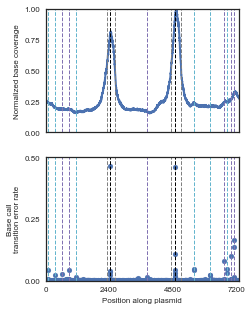

In [21]:
plotPlasmidOffTargets(plasmidOffBases, plasmidOffCov, [2422, 4884], [i for i in topNicks if i not in [2422, 4884]], bottomNicks, peakBounds2, plasmidReference)
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_4C.pdf', bbox_inches = 'tight', transparent = 'True')

In [22]:
temp = pd.DataFrame()
temp['loci'] = topNicks + bottomNicks
locs = [i for i in temp.loci if i not in [2422, 4884]]
locs.sort()
temp['strand'] = [True] * len(topNicks) + [False] * len(bottomNicks)
temp['signal'] = 0
temp['seq'] = 0
temp['n'] = 0
for i in temp.index:
    if temp.loc[i, 'loci'] == 2422:
        temp.loc[i, 'n'] = 'On target 1'
    elif temp.loc[i, 'loci'] == 4884:
        temp.loc[i, 'n'] = 'On target 2'
    else:
        temp.loc[i, 'n'] = 'Off target ' + str(np.where(locs == temp.loc[i, 'loci'])[0][0] + 1)
        
    locus = temp.loc[i, 'loci'] + temp.loc[i, 'strand']
    temp.loc[i, 'signal'] = plasmidOffBases[locus].loc[baseTransitions(plasmidReference[locus])]
    
    if temp.loc[i, 'strand']:
        temp.loc[i, 'seq'] = reverseComplement(plasmidReference[temp.loc[i, 'loci'] - 1:temp.loc[i, 'loci'] + 6])
    else:
        temp.loc[i, 'seq'] = plasmidReference[temp.loc[i, 'loci'] - 4:temp.loc[i, 'loci'] + 3]
temp = temp.sort_values('signal', ascending = False)

target = 'GAATGCN'
print('Name\t\tLocus\tStrand\tSequence\tTransition rate\t\t-log(MACS2 q score)')
for _, row in temp.iterrows():
    print(row.n + '\t' + str(row.loci), end = '\t')
    if row.strand:
        print('+', end = '\t')
    else:
        print('-', end = '\t')
    for i in range(len(target)):
        if target[i] == 'N' or target[i] == row.seq[i]:
            cprint(row.seq[i], 'blue', end = '')
        else:
            cprint(row.seq[i], 'red', end = '')
    print('\t\t' + str(row.signal), end = '\t')
    if row.loci == 2422:
        print(peakQ2[0])
    elif row.loci == 4884:
        print(peakQ2[1])
    else:
        print('n.a.')

Name		Locus	Strand	Sequence	Transition rate		-log(MACS2 q score)
On target 1	2422	+	GAATGCG		0.4643551740325934	331.68753
On target 2	4884	+	GAATGCC		0.4615655675811729	833.05078
Off target 12	7095	+	GAACGCG		0.13563659628918745	n.a.
Off target 11	7011	+	GAATGAC		0.0988042794210195	n.a.
Off target 9	6726	+	GGATGCT		0.07994955863808323	n.a.
Off target 10	6836	-	GGATGCA		0.04880952380952381	n.a.
Off target 7	5605	-	GAACGCC		0.044005544005544	n.a.
Off target 4	889	+	AAATGCC		0.0430786904078116	n.a.
Off target 1	105	-	GAATGTG		0.042616033755274264	n.a.
Off target 3	625	+	GACTGCC		0.0279305966991113	n.a.
Off target 8	6201	-	GAGTGCC		0.02555366269165247	n.a.
Off target 2	354	-	GAATGTC		0.02284626368396002	n.a.
Off target 5	1138	-	GAATGAC		0.017179023508137433	n.a.
Off target 6	3835	+	AAATGCA		0.016329704510108865	n.a.


In [23]:
if printFigures:
    workbook = xlsxwriter.Workbook(figurePrint_dir + 'Table_S2.xlsx')
    worksheet = workbook.add_worksheet()

    b = workbook.add_format({'color': 'blue'})
    r = workbook.add_format({'color': 'red'})

    worksheet.write(0, 0, 'Nicking endonuclease Nb.BSMI recognition sequence: GAATGCN')

    headings = ['Name', 'Locus', 'Strand', 'Sequence', 'Transition rate', '-log(MACS2 q score)']
    for i in range(len(headings)):
        worksheet.write(2, i, headings[i])

    count = 2
    for _, row in temp.iterrows():
        count += 1
        worksheet.write(count, 0, row.n)
        worksheet.write(count, 1, row.loci)
        if row.strand:
            worksheet.write(count, 2, '+')
        else:
            worksheet.write(count, 2, '-')
        f = []
        for i in range(len(target)):
            if target[i] == 'N' or target[i] == row.seq[i]:
                f.append(b)
            else:
                f.append(r)
        worksheet.write_rich_string(count, 3, '', f[0], row.seq[0], f[1], row.seq[1], f[2], row.seq[2], f[3], row.seq[3], f[4], row.seq[4], f[5], row.seq[5], f[6], row.seq[6])
        worksheet.write(count, 4, row.signal)
        if row.loci == 2422:
            worksheet.write(count, 5, str(peakQ2[0]))
        elif row.loci == 4884:
            worksheet.write(count, 5, str(peakQ2[1]))
        else:
            worksheet.write(count, 5, 'n.a.')

    workbook.close()

In [24]:
plasmidReference2 = readReference(data_dir + 'fig4/pMN00_targetInsertAAVS1.fasta', 'pMN00_target')
plasmidCas9Bases, plasmidCas9Cov = getData(data_dir + 'fig4/plasmid_cas9nickase', 'pMN00_target')

cas9nicks = []
for match in re.finditer('ACTAGGGACAGGAT', plasmidReference2):
    cas9nicks.append(match.start() + 10.5)
for match in re.finditer(reverseComplement('ACTAGGGACAGGAT'), plasmidReference2):
    cas9nicks.append(match.start() + 2.5)

# os.system('macs2 callpeak -t ' + data_dir + 'fig4/plasmid_cas9nickase.sorted.bam -f BAMPE -q 0.95 -g 7305 --nomodel -n ' + data_dir + 'fig4/plasmid_cas9nickase')
plasmidPeaks3 = loadPeaks(data_dir + 'fig4/plasmid_cas9nickase_peaks.xls')
peakBounds3 = sorted(list(plasmidPeaks3.start) + list(plasmidPeaks3.end))
peakQ3 = list(plasmidPeaks3.logQ)

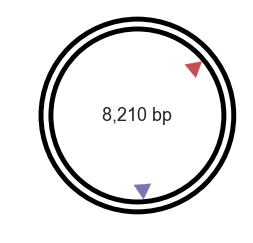

In [25]:
plotCircle(len(plasmidReference2), bottomNicks = cas9nicks, bottomColors = [red, purple])
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_4C.pdf', bbox_inches = 'tight', transparent = 'True')

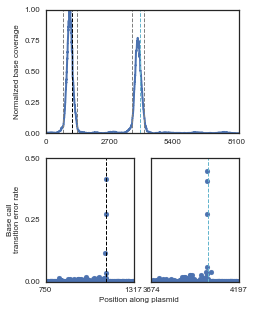

In [26]:
plotPlasmidOffTargets(plasmidCas9Bases[0], plasmidCas9Cov, [cas9nicks[0]], [], [cas9nicks[1]], peakBounds3, plasmidReference2, True)
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_4D.pdf', bbox_inches = 'tight', transparent = 'True')

In [27]:
target = 'GGGGCCACTAGGGACAGGAT'
print('Name\t\tLocus\tStrand\tSequence\t\tPAM\t-log(MACS2 q score)\tTransition rate')

print('On target\t' + str(round(cas9nicks[0])) + '\t-', end = '\t')
seq = plasmidReference2[round(cas9nicks[0]) - 17:round(cas9nicks[0]) + 6]
for i in range(len(target)):
    if target[i] == 'N' or target[i] == seq[i]:
        cprint(seq[i], 'blue', end = '')
    else:
        cprint(seq[i], 'red', end = '')      
locus = round(cas9nicks[0]) - 1
cprint('\t' + seq[-3:], 'blue', end = '\t')
print(str(peakQ3[0]) + '\t\t' + str(plasmidCas9Bases[0][locus].loc[baseTransitions(plasmidReference2[locus])]))

print('Off target\t' + str(round(cas9nicks[1])) + '\t-', end = '\t')
seq = plasmidReference2[round(cas9nicks[1]) - 17:round(cas9nicks[1]) + 6]
for i in range(len(target)):
    if target[i] == 'N' or target[i] == seq[i]:
        cprint(seq[i], 'blue', end = '')
    else:
        cprint(seq[i], 'red', end = '')
locus = round(cas9nicks[1]) - 1
cprint('\t' + seq[-3:], 'blue', end = '\t')
print(str(peakQ3[1]) + '\t\t' + str(plasmidCas9Bases[0][locus].loc[baseTransitions(plasmidReference2[locus])]))

Name		Locus	Strand	Sequence		PAM	-log(MACS2 q score)	Transition rate
On target	1142	-	GGGGCCACTAGGGACAGGAT	TGG	90.17108		0.6097059179474767
Off target	4010	-	AGCTTTACTAGGGACAGGAT	TGG	70.17111		0.4453575799965029


In [28]:
if printFigures:
    workbook = xlsxwriter.Workbook(figurePrint_dir + 'Table_S3.xlsx')
    worksheet = workbook.add_worksheet()

    b = workbook.add_format({'color': 'blue'})
    r = workbook.add_format({'color': 'red'})

    worksheet.write(0, 0, 'guide RNA sequence: GGGGCCACTAGGGACAGGAT')

    headings = ['Name', 'Locus', 'Strand', 'Sequence', 'PAM', '-log(MACS2 q score)', 'Transition rate']
    for i in range(len(headings)):
        worksheet.write(2, i, headings[i])

    seq = plasmidReference2[round(cas9nicks[0]) - 17:round(cas9nicks[0]) + 6]
    worksheet.write(3, 0, 'On target')
    worksheet.write(3, 1, str(round(cas9nicks[0])))
    worksheet.write(3, 2, '-')
    f = []
    for i in range(len(target)):
        if target[i] == 'N' or target[i] == seq[i]:
            f.append(b)
        else:
            f.append(r)
    worksheet.write_rich_string(3, 3, '', f[0], seq[0], f[1], seq[1], f[2], seq[2], f[3], seq[3], f[4], seq[4], f[5], seq[5], f[6], seq[6], f[7], seq[7], f[8], seq[8], f[9], seq[9], f[10], seq[10], f[11], seq[11], f[12], seq[12], f[13], seq[13], f[14], seq[14], f[15], seq[15], f[16], seq[16], f[17], seq[17], f[18], seq[18], f[19], seq[19])
    worksheet.write_rich_string(3, 4, '', b, seq[-3:])
    worksheet.write(3, 5, peakQ3[0])
    locus = round(cas9nicks[0]) - 1
    worksheet.write(3, 6, str(plasmidCas9Bases[0][locus].loc[baseTransitions(plasmidReference2[locus])]))

    seq = plasmidReference2[round(cas9nicks[1]) - 17:round(cas9nicks[1]) + 6]
    worksheet.write(4, 0, 'Off target')
    worksheet.write(4, 1, str(round(cas9nicks[1])))
    worksheet.write(4, 2, '-')
    f = []
    for i in range(len(target)):
        if target[i] == 'N' or target[i] == seq[i]:
            f.append(b)
        else:
            f.append(r)
    worksheet.write_rich_string(4, 3, '', f[0], seq[0], f[1], seq[1], f[2], seq[2], f[3], seq[3], f[4], seq[4], f[5], seq[5], f[6], seq[6], f[7], seq[7], f[8], seq[8], f[9], seq[9], f[10], seq[10], f[11], seq[11], f[12], seq[12], f[13], seq[13], f[14], seq[14], f[15], seq[15], f[16], seq[16], f[17], seq[17], f[18], seq[18], f[19], seq[19])
    worksheet.write_rich_string(4, 4, '', b, seq[-3:])
    worksheet.write(4, 5, peakQ3[1])
    locus = round(cas9nicks[1]) - 1
    worksheet.write(4, 6, str(plasmidCas9Bases[0][locus].loc[baseTransitions(plasmidReference2[locus])]))

    workbook.close()

### Figure 5

In [29]:
# can be changed to zero, won't affect result
qCutoff = 0.4

genomeBases, genomeCov = getData(data_dir + 'fig5/Ecoli_genome', 'contig000001')
readCount = genomeBases[1]
genomeBases = genomeBases[0]

genomeReference = readReference(data_dir + 'fig5/Escherichia_coli_ATCC_11303.fasta', 'contig000001')
guideRNA1 = 'GGTCTCCCCATGCGAGAGTA'
guideRNA2 = 'GATCTCCCTGGCGTCGCTGG'

# os.system('macs2 callpeak -t ' + data_dir + 'fig5/Ecoli_genome.sorted.bam -f BAMPE -q 0.95 -g 4600000 -n ' + data_dir + 'fig5/Ecoli_genome')
peaks = loadPeaks()
temp = peaks[peaks.logQ > qCutoff]
print(str(round(sum(peaks.end - peaks.start + 1) / len(genomeReference) * 100, 2)) + '% of genome in a peak')
print(str(round(sum(temp.end - temp.start + 1) / len(genomeReference) * 100, 2)) + '% of genome in a high quality peak\n')
print(str(len(peaks)) + ' MACS2 peaks')
print(str(len(temp)) + ' MACS2 peaks with good enough quality score')

p1 = [1] * len(genomeCov)
p2 = [1] * len(genomeCov)
for _, peak in peaks[peaks.logQ > qCutoff].iterrows():
    for i in range(peak.start - 3, peak.end + 4):
        if not np.isnan(genomeBases[i][baseTransitions(genomeReference[i])]):
            if genomeReference[i] in 'AG':
                error = np.nanmax([genomeBases[i]['C'], genomeBases[i]['T'], 0.05])
            else:
                error = np.nanmax([genomeBases[i]['A'], genomeBases[i]['G'], 0.05])
            p1[i] = binom_test(round(genomeBases[i][baseTransitions(genomeReference[i])] * readCount[i]), readCount[i], error, alternative = 'greater')
            if np.isnan(p1[i]):
                p1[i] = 1
        
    for i in range(peak.start, peak.end):
        p2[i] = min(sorted(p1[i - 3:i + 1])[1], sorted(p1[i:i + 4])[1])

# identify possible nick locations based off low probability of multiple transition mutational signals occuring by chance close to one another
possibleNicks = np.where(np.array(p2) < 1e-10)[0]
# group potential nick locations if they are close together
# (i.e., if multiple potential nicks from earlier are actually consecutive dPTP/dKTP insertions at one nick site)
spacing = possibleNicks[1:] - possibleNicks[:-1]
possibleNicks2 = []
temp = 0
for nickIndex in range(len(spacing)):
    if spacing[nickIndex] > 5:
        possibleNicks2.append([possibleNicks[temp], possibleNicks[nickIndex]])
        temp = nickIndex + 1
possibleNicks2.append([possibleNicks[temp], possibleNicks[-1]])

pkSignal = [0] * len(genomeCov)
for i in possibleNicks2:
    for j in range(i[0] - 10, i[1] + 11):
        temp = np.nanmax(genomeBases[j])
        if np.isnan(temp) or temp == 0:
            pkSignal[j] = 0
        else:
            pkSignal[j] = genomeBases[j][baseTransitions(genomeReference[j])] / genomeBases[j][genomeReference[j]]
# extend possible nick identifications out up to 5 base pairs if there is weaker dPTP/dKTP signal outside of the strong signal used to originally identify the nick
for i in range(len(possibleNicks2)):
    temp = [j for j in range(possibleNicks2[i][0] - 5, possibleNicks2[i][1] + 6) if pkSignal[j] > 0.02]
    possibleNicks2[i] = [temp[0], temp[-1]]
print(str(len(possibleNicks2)) + ' potential nicks based on degenerate signal')
# remove low read count areas
for i in range(len(possibleNicks2) - 1, -1, -1):
    if np.mean(readCount[possibleNicks2[i][0]:possibleNicks2[i][1] + 1]) <= 150:
        del possibleNicks2[i]
print(str(len(possibleNicks2)) + ' potential nicks after removing low read count regions')
# remove areas that could be mutations
for i in range(len(possibleNicks2) - 1, -1, -1):
    for j in range(possibleNicks2[i][0], possibleNicks2[i][1] + 1):
        temp = baseTransitions(genomeReference[j])
        if genomeBases[j][genomeReference[j]] == 0 or genomeBases[j][temp] > genomeBases[j][genomeReference[j]] * 10:
            del possibleNicks2[i]
            break
print(str(len(possibleNicks2)) + ' potential nicks after removing expected mutations contributing to degenerate signal')
# remove sites with low dPTP/dKTP signal
for i in range(len(possibleNicks2) - 1, -1, -1):
    temp = np.array(pkSignal[possibleNicks2[i][0]:possibleNicks2[i][1] + 1])
    length = possibleNicks2[i][1] - possibleNicks2[i][0] + 1
    # delete if small fraction of bases in range show mutational signal
    if not (sum(temp > 0.01) / length >= 0.6 or sum(temp > 3.5) / length >= 0.25):
        del possibleNicks2[i]
    # delete if small absolute number of bases in range show mutational signal
    elif not ((sum(temp > 0.01) >= 5) or sum(temp > 3.5) >= 2):
        del possibleNicks2[i]
print(str(len(possibleNicks2)) + ' potential nicks after removing sites with low dPTP/dKTP signal\n')

calledNicks = []
strand = []
peaks['nicksContained'] = 0
for row, peak in peaks[peaks.logQ > qCutoff].iterrows():
    searchForSecondNick = False
    for i in possibleNicks2:
        if i[0] in range(peak.start, peak.end + 1):
            peaks.loc[row, 'nicksContained'] += 1
            if searchForSecondNick:
                temp = np.argmin(genomeCov[i[0]:peak.end + 1]) + peak.start
                temp = np.argmax(genomeCov[temp:peak.end + 1]) + temp
                if temp > i[1]:
                    calledNicks.append(i[0])
                    strand.append('top')
                else:
                    calledNicks.append(i[1])
                    strand.append('bottom')
            else:
                temp = np.argmax(genomeCov[peak.start:peak.end + 1]) + peak.start
                if temp > i[1]:
                    calledNicks.append(i[0])
                    strand.append('top')
                else:
                    calledNicks.append(i[1])
                    strand.append('bottom')
                searchForSecondNick = True
                
for i in range(len(calledNicks)):
    print('Nick at locus ' + str(calledNicks[i]) + ', ' + strand[i] + ' strand.', end = '\t')
    if strand[i] == 'bottom':
        temp = genomeReference[calledNicks[i] - 16:calledNicks[i] + 8]
    else:
        temp = reverseComplement(genomeReference[calledNicks[i] - 7:calledNicks[i] + 17])
    if hammingDistance(temp[:23], guideRNA1 + 'NGG') == 0 or hammingDistance(temp[1:], guideRNA1 + 'NGG') == 0:
        print('Perfect complementarity to guide RNA 1, NGG PAM.')
    elif hammingDistance(temp[:23], guideRNA1 + 'NGG') == 0 or hammingDistance(temp[1:], guideRNA2 + 'NGG') == 0:
        print('Perfect complementarity to guide RNA 2, NGG PAM.')

21.48% of genome in a peak
14.85% of genome in a high quality peak

3267 MACS2 peaks
1976 MACS2 peaks with good enough quality score
196 potential nicks based on degenerate signal
178 potential nicks after removing low read count regions
91 potential nicks after removing expected mutations contributing to degenerate signal
9 potential nicks after removing sites with low dPTP/dKTP signal

Nick at locus 231867, bottom strand.	Perfect complementarity to guide RNA 1, NGG PAM.
Nick at locus 1142933, bottom strand.	Perfect complementarity to guide RNA 2, NGG PAM.
Nick at locus 2646965, top strand.	Perfect complementarity to guide RNA 1, NGG PAM.
Nick at locus 3349191, top strand.	Perfect complementarity to guide RNA 1, NGG PAM.
Nick at locus 3349437, top strand.	Perfect complementarity to guide RNA 1, NGG PAM.
Nick at locus 3906462, bottom strand.	Perfect complementarity to guide RNA 1, NGG PAM.
Nick at locus 4016944, bottom strand.	Perfect complementarity to guide RNA 1, NGG PAM.
Nick at lo

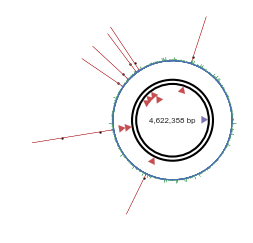

In [30]:
r = 2.85 + (4 * np.concatenate([genomeCov, [genomeCov[0]]]) / max(genomeCov))
theta = math.pi * (0.5 - (2 * np.array(list(range(len(genomeCov))) + [0]) / len(genomeCov)))

def plotLineAroundCircle(start, end, color = blue, lw = 0.4):
    plt.plot(r[start:end] * np.cos(theta[start:end]), r[start:end] * np.sin(theta[start:end]), color = color, linewidth = lw)

plotCircle(len(genomeCov), [calledNicks[i] for i in range(9) if strand[i] == 'top'], [red], [False, False, True], [calledNicks[i] for i in range(9) if strand[i] == 'bottom'], [red, purple, red, red, red, red], [False, False, False, False, False, True], 8)

for _, peak in peaks[(peaks.logQ >= 0.40433) & (peaks.nicksContained == 0)].iterrows():
    plotLineAroundCircle(peak.start - 1, peak.end + 1, green)

start = 0
for _, peak in peaks[peaks.logQ >= 0.40433].iterrows():
    plotLineAroundCircle(start, peak.start)
    start = peak.end
plotLineAroundCircle(start, len(r))

for _, peak in peaks[peaks.nicksContained > 0].iterrows():
    plotLineAroundCircle(peak.start - 1, peak.end + 1, red)
plt.scatter(r[calledNicks] * np.cos(theta[calledNicks]), r[calledNicks] * np.sin(theta[calledNicks]), color = 'k', s = 4)

plt.axis('scaled')
plt.axis('off')

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_5A.pdf', bbox_inches = 'tight', transparent = 'True')

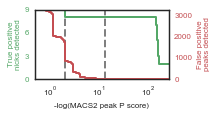

In [31]:
pos = []
neg = []
p = []
temp = peaks.copy()
while not temp.empty:
    numNicks = sum(temp.nicksContained)
    pos.append(numNicks)
    neg.append(len(temp) - numNicks + 1)
    minP = min(temp.logP)
    p.append(minP)
    temp = temp[temp.logP > minP]

fig, ax1 = plt.subplots(figsize = (2.4, 1.28))
    
ax1.axvline(p[neg.index(1)], ls = 'dashed', c = 'gray')
ax1.axvline(p[pos.index(8) - 1], ls = 'dashed', c = 'gray')

ax1.step(p, pos, c = green)
ax1.set_ylim(0, 9)

ax2 = ax1.twinx()
ax2.set_ylim([0, max(neg)])

ax2.step(p, neg, c = red)

ax1.set_xscale('log')
ax1.set_xlim([0, max(p)])

ax1.set_xlabel('-log(MACS2 peak P score)')
ax1.set_ylabel('True positive\nnicks detected', color = green)
ax1.tick_params(axis = 'y', labelcolor = green)
ax2.set_ylabel('False positive\npeaks detected', color = red)
ax2.tick_params(axis = 'y', labelcolor = red)
ax1.set_yticks([0, 3, 6, 9])
ax2.set_yticks([0, 1000, 2000, 3000])

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_5B.pdf', bbox_inches = 'tight', transparent = 'True')

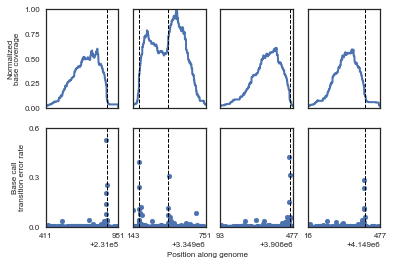

In [32]:
m = max(genomeCov)

fig, _ = plt.subplots(2, 4, sharex = True, sharey = True, figsize = (6, 4))
        
count = 0
count2 = 0
for _, peak in peaks[peaks.nicksContained > 0].iterrows():
    if calledNicks[count] in range(peak.start, peak.end):
        if count in [0, 3, 5, 7]:
            plt.subplot(2, 4, count2 + 1)
            plt.xticks([])
            plt.ylim((0, 1))
            plt.xlim([peak.start, peak.end + 1])
            plt.plot(range(peak.start, peak.end + 1), genomeCov[peak.start:peak.end + 1] / m)
            if count2 == 0:
                plt.ylabel('Normalized\nbase coverage')
                plt.yticks([0, 0.25, 0.5, 0.75, 1])
            else:
                plt.yticks([])
            plt.axvline(calledNicks[count], ls = 'dashed', color = 'black', lw = 1)
            if count == 3:
                plt.axvline(calledNicks[count + 1], ls = 'dashed', color = 'black', lw = 1)

            plt.subplot(2, 4, count2 + 5)
            plt.xlim([peak.start, peak.end + 1])
            plt.ylim([0, 0.6])
            plt.xticks([peak.start, peak.end], horizontalalignment = 'center')
            transition = baseTransitions(genomeReference[peak.start:peak.end + 1])
            plt.scatter(range(peak.start, peak.end + 1), [genomeBases[i + peak.start][transition[i]] for i in range(len(transition))], s = 24)
            if count2 == 0:
                plt.ylabel('Base call\ntransition error rate')
                plt.yticks([0, 0.3, 0.6])
                plt.gca().get_xaxis().get_major_formatter().set_useOffset(231000)
            else:
                plt.yticks([])
            plt.axvline(calledNicks[count], ls = 'dashed', color = 'black', lw = 1)
            if count == 3:
                plt.axvline(calledNicks[count + 1], ls = 'dashed', color = 'black', lw = 1)
            count2 += 1

        count += 1
        if count == 1 or count == 4:
            count += 1
        if count == len(calledNicks):
            break

fig.text(0.5, 0.04, '\nPosition along genome', va = 'center', ha = 'center', fontsize = 8)

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_5C.pdf', bbox_inches = 'tight', transparent = 'True')

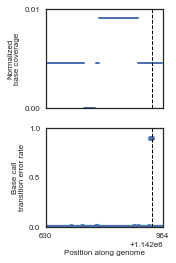

In [33]:
m = max(genomeCov)

plt.figure(figsize = (2.1, 4))
        
for _, peak in peaks[peaks.nicksContained > 0].iterrows():
    if calledNicks[1] in range(peak.start, peak.end):
        plt.subplot(2, 1, 1)
        plt.xticks([])
        plt.ylim((0, 0.01))
        plt.xlim([peak.start, peak.end + 1])
        toPlot = genomeCov[peak.start:peak.end + 1] / m
        jumps = np.where(toPlot[1:] != toPlot[:-1])[0]
        plt.plot([peak.start, peak.start + jumps[0]], [toPlot[0], toPlot[jumps[0]]], c = blue)
        for i in range(1, len(jumps)):
            plt.plot([peak.start + jumps[i - 1] + 1, peak.start + jumps[i]], [toPlot[jumps[i - 1] + 1], toPlot[jumps[i]]], c = blue)
        plt.ylabel('Normalized\nbase coverage')
        plt.yticks([0, 0.01])
        plt.axvline(calledNicks[1], ls = 'dashed', color = 'black', lw = 1)

        plt.subplot(2, 1, 2)
        plt.xlim([peak.start, peak.end + 1])
        plt.ylim([0, 1])
        plt.xticks([peak.start, peak.end], horizontalalignment = 'center')
        transition = baseTransitions(genomeReference[peak.start:peak.end + 1])
        toPlot = np.array([genomeBases[i + peak.start][transition[i]] for i in range(len(transition))])
        nan = np.isnan(toPlot)
        toPlot[nan] = 0
        plt.scatter(range(peak.start, peak.end + 1), toPlot, s = 24)
        plt.ylabel('Base call\ntransition error rate')
        plt.xlabel('\nPosition along genome')
        plt.yticks([0, 0.5, 1])
        plt.gca().get_xaxis().get_major_formatter().set_useOffset(1142000)
        plt.axvline(calledNicks[1], ls = 'dashed', color = 'black', lw = 1)
        break
            
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_5D.pdf', bbox_inches = 'tight', transparent = 'True')

### Figure 6

In [34]:
def hg19CountCoverage(chromosome, peakData, dist = 5000, keep = 0):
    peak = [int(peakData.start) - 1, int(peakData.end)]
    dist = min(dist, peak[0])
    cov = np.array([0] * (peak[1] - peak[0] + 2 * dist))
    count = 0
    for read in samfileCoverage.fetch(chromosome, peak[0] - dist, peak[1] + dist):
        if read.is_proper_pair:
            start = read.reference_start
            stop = read.reference_end
            if start < int(peakData.end) and stop > int(peakData.start):
                count += 1
            mateStart = read.next_reference_start
            if start == mateStart:
                if read.mate_is_reverse:
                    cov[start - peak[0] + dist:stop - peak[0] + dist] += 1
            elif start < mateStart:
                cov[start - peak[0] + dist:mateStart - peak[0] + dist] += 1
            else:
                cov[start - peak[0] + dist:stop - peak[0] + dist] += 1
    if dist == 0:
        start = 0
        end = 0
    else:
        start = np.where(cov[:dist] == 0)[0]
        if len(start) == 0:
                start = 0
        else:
            start = max(start[-1] - dist - 1, 0)
        end = np.where(cov[len(cov) - dist:] == 0)[0]
        if len(end) == 0:
            end = dist - keep
        else:
            end = end[0]
        
    return pd.DataFrame(data = cov[dist + start - keep:len(cov) - dist + end + keep], index = range(int(peakData.start) + start - keep, int(peakData.end) + end + 1 + keep)), count / 2

def hg19CountBases(chromosome, peak):
    c = samfileBases.count_coverage(chromosome, peak[0] - 1, peak[1], quality_threshold = 30)    
    cov = pd.DataFrame()
    for i in index:
        cov = pd.concat([cov, pd.DataFrame(c[i].tolist()).T])
    cov.index = index2
    cov.columns = range(peak[0], peak[1] + 1)
    return cov

def hg19CalculatePK(chromosome, bases):
    pk = pd.DataFrame(data = [0] * bases.shape[1], index = bases.columns)
    s = bases.sum(0)
    for i in bases.columns:
        if s[i] != 0:
            temp = hg19[chromosome][i - 1]
            if temp == 'A':
                pk.loc[i] = bases[i]['G'] / s[i]
            elif temp == 'G':
                pk.loc[i] = bases[i]['A'] / s[i]
            elif temp == 'C':
                pk.loc[i] = bases[i]['T'] / s[i]
            elif temp == 'T':
                pk.loc[i] = bases[i]['C'] / s[i]
    return pk

In [35]:
samfileBases = pysam.AlignmentFile(data_dir + 'fig6/NickSeq_hg19.highMapQ.bam')
samfileCoverage = pysam.AlignmentFile(data_dir + 'fig6/NickSeq_hg19.highMapQ.rmdup.bam')

hg19 = readReference('/Users/jelacqua/Documents/Blainey lab/Reference Sequences/Human/hg19')
temp = list(hg19['chr19'])
# locus appears to have a mutation after sequencing it
temp[55627222] = 'T'
hg19['chr19'] = ''.join(temp)
aavs1 = 'GGGGCCACTAGGGACAGGAT'

#os.system('macs2 callpeak -t ' + data_dir + 'fig6/NickSeq_hg19.highMapQ.bam -f BAMPE -q 0.95 -g hs -n ' + data_dir + 'fig6/NickSeq_hg19')
hgPeaks = loadPeaks(data_dir + 'fig6/NickSeq_hg19_peaks.xls', 24)

blackList = dict()
with open('/Users/jelacqua/Documents/Blainey lab/Reference Sequences/Human/blacklists/hg19-blacklist_allCombined.csv') as textfile:
    for row in textfile:
        temp = row.strip().split(',')
        if temp[0] in blackList:
            blackList[temp[0]].append([int(temp[1]), int(temp[2])])
        else:
            blackList[temp[0]] = [[int(temp[1]), int(temp[2])]]

hgPeaks['blackList'] = False
for i in blackList:
    for j in blackList[i]:
        hgPeaks.loc[(hgPeaks.chromosome == i) & (hgPeaks.start <= j[1]) & (hgPeaks.end >= j[0]), 'blackList'] = True

print(str(len(hgPeaks)) + ' MACS2 peaks')
print(str(len(hgPeaks[hgPeaks.blackList == False])) + ' MACS2 peaks not black listed')
# with hg38, use 'hgPeaks.logQ > 0.6' instead
print(str(len(hgPeaks[(hgPeaks.blackList == False) & (hgPeaks.logQ > 0.4)])) + ' MACS2 peaks not black listed, with good enough quality score')

peaksWithAnyPK = 0
peaksWithNick = []
# with hg38, use 'hgPeaks.logQ > 0.6' instead
for i, row in hgPeaks[(hgPeaks.blackList == False) & (hgPeaks.logQ > 0.4)].sort_values('logQ', ascending = False).iterrows():
    cov, count = hg19CountCoverage(row.chromosome, row)
    bases = hg19CountBases(row.chromosome, [cov.index[0], cov.index[-1]])
    pk = hg19CalculatePK(row.chromosome, bases)
    
    maxMut = 0
    if not hg19[row.chromosome][row.start:row.end + 1].islower():
        boolList = [j.isupper() for j in hg19[row.chromosome][cov.index[0]:cov.index[-1] + 1]]
        boolListCopy = boolList.copy()
        for j in range(1, len(boolList) - 1):
            if not (boolListCopy[j - 1] and boolListCopy[j + 1]):
                boolList[j] = False
        for j in [0, 1, 2]:
            boolList[j] = False
            boolList[-1 - j] = False
        for j in pk.index:
            if pk.loc[j, 0] == 1:
                pk.loc[j, 0] = 0
        if any(boolList):
            maxMut = max(pk.values[boolList, 0])
    
    if count < 100 and maxMut > 0.1:
        peaksWithAnyPK += 1
        n = np.where((pk.values[:, 0] > 0.1) & boolList)[0]
        if len(n) > 1 and min(n[1:] - n[:-1]) < 5:
            ind = pk.index[n[np.where(n[1:] - n[:-1] == min(n[1:] - n[:-1]))[0][0]]]
            flag = True
            for j in range(-2, 3):
                if 100 - np.where(np.array(list(hg19[row.chromosome][ind - j - 100:ind - j])) != hg19[row.chromosome][ind - j])[0][-1] + np.where(np.array(list(hg19[row.chromosome][ind - j + 1:ind - j + 101])) != hg19[row.chromosome][ind - j])[0][0] >= 10:
                    flag = False
                    break
            if flag and sum(bases[ind]) >= 5:
                flag = True
                for j in range(-3, 4):
                    if max(bases.loc[:, ind + j] / sum(bases.loc[:, ind + j])) + pk.loc[ind + j, 0] < 0.65:
                        flag = False
                        break
                if flag:
                    peaksWithNick.append(i)
                    
print(str(peaksWithAnyPK) + ' of these peaks contain any mutational signal')
print(str(len(peaksWithNick)) + ' of these peaks contain mutational signal at near-consecutive locations\n')

toPlot = []
for i, row in hgPeaks.loc[peaksWithNick].iterrows():
    cov, count = hg19CountCoverage(row.chromosome, row)
    bases = hg19CountBases(row.chromosome, [cov.index[0], cov.index[-1]])
    pk = hg19CalculatePK(row.chromosome, bases)
    
    n = np.where((pk.values[:, 0] > 0.1))[0]
    n2 = np.where(n[1:] - n[:-1] < 5)[0]
    loc = [n[n2[0]], n[max(n2) + 1]]
    
    if loc[0] < np.argmax(cov.values):
        loc = loc[0] + cov.index[0]
        strand = 'top'
        seq = reverseComplement(hg19[row.chromosome][loc - 7:loc + 16])
    else:
        loc = loc[1] + cov.index[0]
        strand = 'bottom'
        seq = hg19[row.chromosome][loc - 17:loc + 6]
    
    if i == 9466 or i == 17625:
        toPlot.append([row, loc, strand])
    
    print('Nick at chromosome ' + row.chromosome[3:] + ', locus ' + str(loc) + ', ' + strand + ' strand.', end = '\t\t')
    print(str(hammingDistance(seq, aavs1 + 'NGG')) + ' mismatches to the guide RNA, N' + seq[-2:] + ' PAM.')

22258 MACS2 peaks
22089 MACS2 peaks not black listed
1696 MACS2 peaks not black listed, with good enough quality score
146 of these peaks contain any mutational signal
6 of these peaks contain mutational signal at near-consecutive locations

Nick at chromosome 19, locus 55627123, top strand.		0 mismatches to the guide RNA, NGG PAM.
Nick at chromosome 11, locus 61111253, bottom strand.		4 mismatches to the guide RNA, NGG PAM.
Nick at chromosome 6, locus 36765480, bottom strand.		3 mismatches to the guide RNA, NGG PAM.
Nick at chromosome 1, locus 2836457, top strand.		4 mismatches to the guide RNA, NGG PAM.
Nick at chromosome 20, locus 31034836, top strand.		3 mismatches to the guide RNA, NGG PAM.
Nick at chromosome 12, locus 108581682, top strand.		3 mismatches to the guide RNA, NGG PAM.


In [36]:
def hgPlot(row, target, strand, title):
    cov, _ = hg19CountCoverage(row.chromosome, row, keep = 2000)
    bases = hg19CountBases(row.chromosome, [cov.index[0], cov.index[-1]])
    pk = hg19CalculatePK(row.chromosome, bases)
    
    fig = plt.figure(figsize = (2.25, 4.5))

    ax = fig.add_subplot(plt.GridSpec(3, 1, hspace = 0.18)[0])
    toPlot = np.array(cov)
    jumps = np.where(toPlot[1:] != toPlot[:-1])[0]
    ax.plot([cov.index[0], cov.index[0] + jumps[0]], [toPlot[0], toPlot[jumps[0]]], lw = 3.5)
    for i in range(1, len(jumps)):
        ax.plot([cov.index[0] + jumps[i - 1] + 1, cov.index[0] + jumps[i]], [toPlot[jumps[i - 1] + 1], toPlot[jumps[i]]], lw = 3.5, c = blue)
    ax.set_xlim(row.start - 1650, row.end + 1650)
    ax.set_ylim(0, 11)
    ax.axvline(row.start - 50, c = 'gray', ls = 'dashed', lw = 1)
    ax.axvline(row.end + 50, c = 'gray', ls = 'dashed', lw = 1)
    ax.axvline(target, c = 'black', ls = 'dashed', lw = 1)
    ax.set_xticks([row.start - 1650, row.end + 1650])
    ax.set_ylabel('De-duplicated coverage')
    ax.set_yticks(range(0, 12, 2))
    ax.set_title(title)
    plt.gca().get_xaxis().get_major_formatter().set_useOffset(math.floor(cov.index[0] / 10000) * 10000)
    
    ax = fig.add_subplot(plt.GridSpec(3, 1, hspace = 0.18)[1])
    toPlot = pk
    jumps = np.where([toPlot.loc[i] != toPlot.loc[i - 1] for i in toPlot.index[1:]])[0]
    ax.plot([toPlot.index[0], toPlot.index[0] + jumps[0]], [toPlot.iloc[0], toPlot.iloc[jumps[0]]], lw = 3.5)
    for i in range(1, len(jumps)):
        ax.plot([toPlot.index[0] + jumps[i - 1] + 1, toPlot.index[0] + jumps[i]], [toPlot.iloc[jumps[i - 1] + 1], toPlot.iloc[jumps[i]]], lw = 3.5, c = blue)
    solo = jumps[1:][jumps[1:] == jumps[:-1] + 1]
    ax.scatter(toPlot.index[solo], toPlot.iloc[solo], s = 12.5)
    ax.set_ylim(0, 1.1)
    ax.set_xlim(row.start - 50, row.end + 50)
    ax.set_xticks([row.start - 50, row.end + 50])
    ax.set_yticks([0, 0.5, 1])
    ax.axvline(target, c = 'black', ls = 'dashed', lw = 1)
    ax.set_xlabel('Position along chromosome ' + row.chromosome[3:])
    ax.set_ylabel('Base call\ntransition error rate')
    plt.gca().get_xaxis().get_major_formatter().set_useOffset(math.floor(cov.index[0] / 10000) * 10000)
    
    ax = fig.add_subplot(plt.GridSpec(3, 1, hspace = 0.5)[2])
    sns.despine(ax = ax)
    ax.set_ylim([0, 1.05])
    flag = True
    if strand == 'top':
        r = range(target - 6, target + 17)
        r2 = 6
        seq = hg19[row.chromosome][target - 7:target + 16]
    else:
        r = range(target - 16, target + 7)
        r2 = 16
        seq = hg19[row.chromosome][target - 17:target + 6]
    for l in r:
        if l in bases.columns:
            ini = bases[l] / sum(bases[l])
            p1 = ax.bar(l - target + r2, ini.loc['A'], color = blue, edgecolor = blue, label = 'A')
            p2 = ax.bar(l - target + r2, ini.loc['C'], bottom = ini.loc['A'], color = green, edgecolor = green, label = 'C')
            p3 = ax.bar(l - target + r2, ini.loc['T'], bottom = ini.loc['A'] + ini.loc['C'], color = red, edgecolor = red, label = 'T')
            p4 = ax.bar(l - target + r2, ini.loc['G'], bottom = ini.loc['A'] + ini.loc['C'] + ini.loc['T'], color = purple, edgecolor = purple, label='G')
            if flag:
                ax.legend(loc = "upper left", bbox_to_anchor = (1, 1))
                flag = False
    ax.set_xlim(-0.7, 22.65)
    ax.set_ylabel('Fraction of reads')
    ax.set_yticks([0, 0.5, 1])
    plt.xticks(range(23), [i for i in seq])
    count = 0
    for label in ax.get_xticklabels():
        if (strand == 'top' and count < 3) or (strand == 'bottom' and count >= 20):
            label.set_color(green)
        elif (strand == 'top' and reverseComplement(seq[count]) == aavs1[2 - count]) or (strand == 'bottom' and seq[count] == aavs1[count]):
            label.set_color(blue)
        else:
            label.set_color(red)
        count += 1

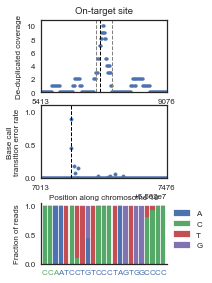

In [37]:
hgPlot(toPlot[0][0], toPlot[0][1], toPlot[0][2], 'On-target site')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6A.pdf', bbox_inches = 'tight', transparent = 'True')

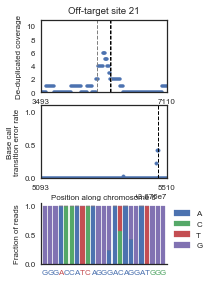

In [38]:
hgPlot(toPlot[1][0], toPlot[1][1], toPlot[1][2], 'Off-target site 21')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6B.pdf', bbox_inches = 'tight', transparent = 'True')

In [39]:
potentialOfftargets = dict()
potentialOfftargets['chromosome'] = []
potentialOfftargets['locus'] = []
potentialOfftargets['strand'] = []
potentialOfftargets['mismatches'] = []
potentialOfftargets['bulgeDNA'] = []
potentialOfftargets['bulgeRNA'] = []
with open(data_dir + 'fig6/aavs1CasOFFinder_hg19.txt') as textfile:
    for row in textfile:
        text = row.split('\t')
        potentialOfftargets['chromosome'].append(text[1])
        potentialOfftargets['strand'].append(text[4] == '-')
        if potentialOfftargets['strand'][-1]:
            potentialOfftargets['locus'].append(int(text[2]) + 6)
        else:
            potentialOfftargets['locus'].append(int(text[2]) + 16)
        potentialOfftargets['mismatches'].append(int(text[5][0]))
        potentialOfftargets['bulgeDNA'].append(0)
        potentialOfftargets['bulgeRNA'].append(0)
with open(data_dir + 'fig6/aavs1CasOFFinder_hg19_bulge.txt') as textfile:
    next(textfile)
    for row in textfile:
        text = row.split('\t')
        if text[0] == 'X':
            continue
        elif text[0] == 'DNA':
            potentialOfftargets['strand'].append(text[5] == '-')
            if potentialOfftargets['strand'][-1]:
                potentialOfftargets['locus'].append(int(text[4]) + 6 + text[1].count('-', len(text[1]) - 6))
            else:
                potentialOfftargets['locus'].append(int(text[4]) + 16 + text[1].count('-', 0, len(text[1]) - 6))
            potentialOfftargets['bulgeDNA'].append(int(text[7][0]))
            potentialOfftargets['bulgeRNA'].append(0)
        else:
            potentialOfftargets['bulgeDNA'].append(0)
            potentialOfftargets['bulgeRNA'].append(int(text[7][0]))
            potentialOfftargets['strand'].append(text[5] == '-')
            if potentialOfftargets['strand'][-1]:
                potentialOfftargets['locus'].append(int(text[4]) + 6)
            else:
                potentialOfftargets['locus'].append(int(text[4]) + 16)
        potentialOfftargets['chromosome'].append(text[3])
        potentialOfftargets['mismatches'].append(int(text[6]))
potentialOfftargets = pd.DataFrame(potentialOfftargets)[['chromosome', 'locus', 'strand', 'mismatches', 'bulgeDNA', 'bulgeRNA']]

In [40]:
potentialOfftargets['mutation'] = float('nan')
potentialOfftargets['mutation2'] = float('nan')
for i in potentialOfftargets.index:
    if potentialOfftargets.loc[i, 'strand']:
        bases = np.asarray(samfileBases.count_coverage(potentialOfftargets.loc[i, 'chromosome'], potentialOfftargets.loc[i, 'locus'], potentialOfftargets.loc[i, 'locus'] + 5, quality_threshold = 30))
        ref = hg19[potentialOfftargets.loc[i, 'chromosome']][potentialOfftargets.loc[i, 'locus']:potentialOfftargets.loc[i, 'locus'] + 5].upper()
    else:
        bases = np.asarray(samfileBases.count_coverage(potentialOfftargets.loc[i, 'chromosome'], potentialOfftargets.loc[i, 'locus'] - 4, potentialOfftargets.loc[i, 'locus'] + 1, quality_threshold = 30))
        ref = hg19[potentialOfftargets.loc[i, 'chromosome']][potentialOfftargets.loc[i, 'locus'] - 4:potentialOfftargets.loc[i, 'locus'] + 1].upper()
    bases = bases / sum(bases, 0)
    m = 0
    for j in range(bases.shape[1]):
        if ref[j] == 'A':
            m = max(m, bases[2, j])
        elif ref[j] == 'C':
            m = max(m, bases[3, j])
        elif ref[j] == 'G':
            m = max(m, bases[0, j])
        elif ref[j] == 'T':
            m = max(m, bases[1, j])
    potentialOfftargets.loc[i, 'mutation'] = m
for i in potentialOfftargets[potentialOfftargets.mutation >= 0.1].index:
    if potentialOfftargets.loc[i, 'strand']:
        bases = np.asarray(samfileBases.count_coverage(potentialOfftargets.loc[i, 'chromosome'], potentialOfftargets.loc[i, 'locus'], potentialOfftargets.loc[i, 'locus'] + 5, quality_threshold = 30))
        ref = hg19[potentialOfftargets.loc[i, 'chromosome']][potentialOfftargets.loc[i, 'locus']:potentialOfftargets.loc[i, 'locus'] + 5].upper()
    else:
        bases = np.asarray(samfileBases.count_coverage(potentialOfftargets.loc[i, 'chromosome'], potentialOfftargets.loc[i, 'locus'] - 4, potentialOfftargets.loc[i, 'locus'] + 1, quality_threshold = 30))
        ref = hg19[potentialOfftargets.loc[i, 'chromosome']][potentialOfftargets.loc[i, 'locus'] - 4:potentialOfftargets.loc[i, 'locus'] + 1].upper()
    bases = bases / sum(bases, 0)
    m = []
    for j in range(bases.shape[1]):
        if ref[j] == 'A':
            m.append(bases[2, j])
        elif ref[j] == 'C':
            m.append(bases[3, j])
        elif ref[j] == 'G':
            m.append(bases[0, j])
        elif ref[j] == 'T':
            m.append(bases[1, j])
    m.sort()
    m = [j for j in m if not np.isnan(j)]
    if len(m) > 2:
        potentialOfftargets.loc[i, 'mutation2'] = m[-2]
samfileCoverage.close()
samfileBases.close()

In [41]:
hits = potentialOfftargets[(potentialOfftargets.mutation2 >= 0.1) & (potentialOfftargets.mutation2 < 1)].copy()

# remove duplicate hits that arise because Cas-OFFinder allows for DNA/RNA bulges
# for example, the on target site comes up as having zero mismatches
# and as having mismatches and a DNA bulge at the 5' end of the guide RNA
hits['duplicate'] = False
for i, row in hits.iterrows():
    if not row.duplicate:
        temp = hits[(hits.chromosome == row.chromosome) & (abs(hits.locus - row.locus) <= 2)]
        if len(temp) > 1:
            hits.loc[temp.index, 'duplicate'] = True
            if any(temp.bulgeDNA + temp.bulgeRNA == 0):
                hits.loc[temp[temp.bulgeDNA + temp.bulgeRNA == 0].index, 'duplicate'] = False
            else:
                hits.loc[temp.iloc[0].name, 'duplicate'] = False
hits = hits.drop(index = hits[hits.duplicate].index)

hits['macs2'] = float('nan')
for i, row in hits.iterrows():
    temp = hgPeaks[(hgPeaks.chromosome == row.chromosome) & (hgPeaks.start - 100 < row.locus) & (hgPeaks.end + 100 > row.locus)]
    if len(temp) > 0:
        hits.loc[i, 'macs2'] = temp.index[0]

def printRow(row, count):
    if row.mismatches == 0:
        print('AAVS1', end = '\t')
        flag = False
    else:
        print('Off ' + str(count), end = '\t')
        flag = True
    
    print(row.chromosome, end = '\t\t')
    
    print(str(row.locus), end = '\t\t' if row.locus < 10000000 else '\t')
        
    if row.strand:
        print('+', end = '\t')
        seq = reverseComplement(hg19[row.chromosome][row.locus - 6:row.locus + 17].upper())
    else:
        print('-', end = '\t')
        seq = hg19[row.chromosome][row.locus - 16:row.locus + 7].upper()
        
    if row.bulgeRNA > 0:
        if row.chromosome == 'chr11':
            seq = seq[:-7] + '--' + seq[-7:-2]
        elif row.chromosome == 'chr14':
            seq = seq[:10] + '--' + seq[10:-2]
        
    for i in range(len(aavs1)):
        if aavs1[i] == seq[i]:
            cprint(seq[i], 'blue', end = '')
        else:
            cprint(seq[i], 'red', end = '')
    print(end = '\t')
    
    pam = 'NGG'
    for i in range(3):
        if pam[i] != 'N' and pam[i] != seq[i + 20]:
            cprint(seq[i + 20], 'red', end = '')
        else:
            cprint(seq[i + 20], 'blue', end = '')
    print(end = '\t')
    
    if np.isnan(row.macs2):
        print('n.a.', end = '\t\t')
    else:
        print(hgPeaks.loc[row.macs2, 'logQ'], end = '\t\t')
    
    print(round(row.mutation2, 5))
    
    return flag

count = 1
print('Name\tChromosome\tLocus\t\tStrand\tSequence\t\tPAM\t-log(MACS2 q)\tTransition rate')
for i in range(1, 23):
    temp = hits[hits.chromosome == 'chr' + str(i)].copy()
    temp = temp.sort_values('locus')
    for _, row in temp.iterrows():
        if printRow(row, count):
            count += 1
temp = hits[hits.chromosome == 'chrX'].copy()
for _, row in temp.iterrows():
    if printRow(row, count):
        count += 1

Name	Chromosome	Locus		Strand	Sequence		PAM	-log(MACS2 q)	Transition rate
Off 1	chr1		2836456		+	GGGACCTCCAGGGACAGGAC	GGG	1.50985		0.35
Off 2	chr1		4080070		+	TGGGGCCACAGGGACAGGAC	AGG	0.27097		0.4
Off 3	chr1		20020462	+	GCAATTAACAGGAACAGGAT	TGG	n.a.		0.22222
Off 4	chr1		95200632	-	CAGGGGCACCGGGACAGGAT	GGG	n.a.		0.4
Off 5	chr1		172529245	-	TAGGGGCCCAGAGACAGGAT	GAG	0.07919		0.38462
Off 6	chr1		181190082	+	GGAGCCATGAGGGACAGGAG	GGG	0.27097		0.5
Off 7	chr1		232797742	+	GTGACCACTCAGGACAGGTT	GGG	0.27097		0.25581
Off 8	chr1		239493007	+	GGAGCCCCTAGAAACAGAAT	GAG	n.a.		0.3
Off 9	chr2		138300885	-	TCAGAATCTAAGGACAGGAT	GGG	n.a.		0.6
Off 10	chr3		46313787	+	TGGGGTCCACAGGGCAGGAT	TGG	0.07919		0.33333
Off 11	chr3		148674158	+	CAGGGCTTTAGGGACAGGAT	GAG	n.a.		0.14286
Off 12	chr4		92258747	+	AGAGGAACTAGGAACAGGAT	GAG	n.a.		0.10256
Off 13	chr4		160183199	+	TGGGGAACCAGACACAGGAT	GGG	n.a.		0.63636
Off 14	chr5		16825712	+	CTGGGCACTGGGGACAAGAT	GGG	n.a.		0.66667
Off 15	chr5		92665932	+	TGGTCCATTGTGGAACGGAA	CGG	n.

Off 49	chr20		31034835	+	GGGGCCAGTAGGGGCAGGAC	AGG	1.37413		0.24324
Off 50	chr21		42892947	+	GGGGCCCCTGGGGACAGAAT	GGG	n.a.		0.16667
Off 51	chr22		20781846	-	TGGGCCACTGGGGAAGGATG	AGG	n.a.		0.6875
Off 52	chr22		48542338	-	CTCACCCCTAAGGACAGGAT	GAG	n.a.		0.25
Off 53	chrX		31811312	-	GGTTTTTATAGGCACAGGAT	GGG	n.a.		0.66667


In [42]:
tan = pd.read_excel(data_dir + 'fig6/tan off targets.xlsx', sheet_name = 'human_off-targets')
tan = tan[tan.id == 'AAVS1'].copy()
tan['identified'] = False
tan.loc[(tan.chr == 19) & (tan.start == 55627117), 'identified'] = True
tan.loc[(tan.chr == 6) & (tan.start == 36765464), 'identified'] = True
tan.loc[(tan.chr == 13) & (tan.start == 106612912), 'identified'] = True
tan.loc[(tan.chr == 19) & (tan.start == 16174987), 'identified'] = True
tan.loc[(tan.chr == 19) & (tan.start == 45650858), 'identified'] = True
tan.loc[(tan.chr == 21) & (tan.start == 42892942), 'identified'] = True

wang = dict()
wang['chromosome'] = ['chr' + str(i) for i in [19, 19, 8, 21, 2, 22, 8, 13, 15, 12, 11, 2, 20, 20]]
wang['start'] = [55627117, 16174987, 22635581, 42892942, 232824540, 44699098, 144885120, 37196607, 45827893, 108581676, 47446589, 60390559, 42338563, 31034830]
wang['end'] = [55627139, 16175009, 22635603, 42892964, 232824562, 44699120, 144885142, 37196629, 45827915, 108581698, 47446611, 60390581, 42338585, 31034852]
wang['identified'] = [True, True, True, True, True, True, True, True, False, False, False, False, False, False]
wang = pd.DataFrame(wang)

def xlsxRow(worksheet, row, count, count2, b, r):
    if row.mismatches == 0:
        worksheet.write(count2, 0, 'AAVS1')
        flag = False
    else:
        worksheet.write(count2, 0, 'Off ' + str(count))
        flag = True
    
    worksheet.write(count2, 1, row.chromosome)
    
    worksheet.write(count2, 2, str(row.locus))
        
    if row.strand:
        worksheet.write(count2, 3, '+')
        seq = reverseComplement(hg19[row.chromosome][row.locus - 6:row.locus + 17].upper())
    else:
        worksheet.write(count2, 3, '-')
        seq = hg19[row.chromosome][row.locus - 16:row.locus + 7].upper()
    
    if row.bulgeRNA > 0:
        if row.chromosome == 'chr11':
            seq = seq[:-7] + '--' + seq[-7:-2]
        elif row.chromosome == 'chr14':
            seq = seq[:10] + '--' + seq[10:-2]
    
    f = []
    for i in range(len(aavs1)):
        if aavs1[i] == 'N' or aavs1[i] == seq[i]:
            f.append(b)
        else:
            f.append(r)
    worksheet.write_rich_string(count2, 4, '', f[0], seq[0], f[1], seq[1], f[2], seq[2], f[3], seq[3], f[4], seq[4], f[5], seq[5], f[6], seq[6], f[7], seq[7], f[8], seq[8], f[9], seq[9], f[10], seq[10], f[11], seq[11], f[12], seq[12], f[13], seq[13], f[14], seq[14], f[15], seq[15], f[16], seq[16], f[17], seq[17], f[18], seq[18], f[19], seq[19])
    
    pam = 'NGG'
    f = []
    for i in range(3):
        if pam[i] != 'N' and pam[i] != seq[i + 20]:
            f.append(r)
        else:
            f.append(b)
    worksheet.write_rich_string(count2, 5, '', f[0], seq[20], f[1], seq[21], f[2], seq[22])
    
    if np.isnan(row.macs2):
        worksheet.write_rich_string(count2, 6, '', r, 'n.a.')
    else:
        worksheet.write_rich_string(count2, 6, '', b, str(hgPeaks.loc[row.macs2, 'logQ']))
    
    worksheet.write(count2, 7, str(row.mutation2))
    
    temp = tan[(pd.Series(['chr' + str(i) for i in tan.chr]) == row.chromosome) & (row.locus < tan.end) & (row.locus > tan.start)]
    if len(temp) == 1 and temp['Primers designed'].iloc[0] == 'Y':
        if temp.identified.iloc[0]:
            worksheet.write_rich_string(count2, 8, '', b, 'Yes')
        else:
            worksheet.write_rich_string(count2, 8, '', r, 'No')
    else:
        worksheet.write(count2, 8, 'n.a.')
        
    temp = wang[(wang.chromosome == row.chromosome) & (row.locus < wang.end) & (row.locus > wang.start)]
    if len(temp) == 1:
        if temp.identified.iloc[0]:
            worksheet.write_rich_string(count2, 9, '', b, 'Yes')
        else:
            worksheet.write_rich_string(count2, 9, '', r, 'No')
    else:
        worksheet.write(count2, 9, 'n.a.')
    
    if row.name in [175271, 420892, 577476, 56544, 357720, 198501]:
        worksheet.write_rich_string(count2, 10, '', b, 'Yes')
    else:
        worksheet.write(count2, 10, 'No')

    return flag

if printFigures:
    workbook = xlsxwriter.Workbook(figurePrint_dir + 'Table_S4.xlsx')
    worksheet = workbook.add_worksheet()

    b = workbook.add_format({'color': 'blue'})
    r = workbook.add_format({'color': 'red'})

    worksheet.write(0, 0, 'guide RNA sequence: GGGGCCACTAGGGACAGGAT')
    headings = ['Name', 'Chromosome', 'Locus', 'Strand', 'Sequence', 'PAM', '-log(MACS2 q score)', 'Transition rate', 'Identified by Tan et al. (2014)', 'Identified by Wang et al. (2014)', 'Identified without a priori knowledge']
    for i in range(len(headings)):
        worksheet.write(2, i, headings[i])

    count = 1
    count2 = 2
    for i in range(1, 23):
        temp = hits[hits.chromosome == 'chr' + str(i)].copy()
        temp = temp.sort_values('locus')
        for _, row in temp.iterrows():
            count2 += 1
            if xlsxRow(worksheet, row, count, count2, b, r):
                count += 1
    temp = hits[hits.chromosome == 'chrX'].copy()
    for _, row in temp.iterrows():
        count2 += 1
        if xlsxRow(worksheet, row, count, count2, b, r):
            count += 1

    workbook.close()

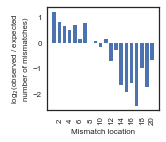

In [43]:
hitSeqs = []
for _, row in hits[hits.bulgeRNA + hits.bulgeDNA == 0].iterrows():
    if row.strand:
        hitSeqs.append(list(reverseComplement(hg19[row.chromosome][row.locus - 6:row.locus + 17].upper())))
    else:
        hitSeqs.append(list(hg19[row.chromosome][row.locus - 16:row.locus + 7].upper()))
hitSeqs = np.array(hitSeqs)

allSeqs = []
for _, row in potentialOfftargets[potentialOfftargets.bulgeRNA + potentialOfftargets.bulgeDNA == 0].iterrows():
    if row.strand:
        allSeqs.append(list(reverseComplement(hg19[row.chromosome][row.locus - 6:row.locus + 17].upper())))
    else:
        allSeqs.append(list(hg19[row.chromosome][row.locus - 16:row.locus + 7].upper()))
allSeqs = np.array(allSeqs)

hitMismatches = np.zeros(20)
allMismatches = np.zeros(20)
for i in range(len(hitMismatches)):
    hitMismatches[i] = sum(hitSeqs[:, i] != aavs1[i])
    allMismatches[i] = sum(allSeqs[:, i] != aavs1[i])
hitMismatches = hitMismatches / sum(hitMismatches)
allMismatches = allMismatches / sum(allMismatches)

fig = plt.figure(figsize = (2, 1.9))

plt.bar(range(1, 21), np.log2(hitMismatches / allMismatches), width = 0.7)

plt.ylabel('log$_2$(observed / expected\nnumber of mismatches)')
plt.xlabel('Mismatch location')
plt.xticks(range(2, 21, 2), rotation = 'vertical', verticalalignment = 'center', horizontalalignment = 'center')
plt.gca().tick_params(axis = 'x', which = 'major', pad = 10)
plt.yticks([-2, -1, 0, 1])

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6D.pdf', bbox_inches = 'tight', transparent = 'True')

In [44]:
def calculatePPM(sequences):
    sequences = np.array([list(i) for i in sequences])

    pfm = np.zeros((23, 4))
    for i in range(pfm.shape[0]):
        for j in range(pfm.shape[1]):
            pfm[i, j] = sum(sequences[:, i] == index2[j])

    return pfm / len(sequences)

def bootstrapPPM(dataframe, sort_column, ascending = True):
    bootstrap = dataframe.iloc[np.random.randint(0, len(dataframe), len(dataframe))]
    bootstrapSeqs = bootstrap.sort_values(sort_column, ascending = ascending).iloc[0:52].seq
    return calculatePPM(bootstrapSeqs)

def plotSequenceLogo(ppm, bootstraps = None, title = ''):
    ic = np.zeros(23)
    for i in range(ic.shape[0]):
        ic[i] = sum(ppm[i, ppm[i, :] > 0] * np.log2(ppm[i, ppm[i, :] > 0] / 0.25))

    logo = np.zeros((23, 4))
    for i in range(logo.shape[0]):
        logo[i, :] = ic[i] * ppm[i, :]
    logo = pd.DataFrame(logo, range(1, 24), index2)

    logo = logomaker.Logo(logo, font_name = 'Arial', figsize = (5.6, 1.5))
    logo.highlight_position_range(21, 23, alpha = 0.3, color = 'lightgray')

    plt.xticks([])
    plt.yticks([])
    plt.ylim(0, 2)
    sns.despine()
    plt.title(title)
    
    if not bootstraps is None:
        errorBars = np.percentile(bootstraps, [5, 95], 0)
        for i in range(4):
            p5 = errorBars[0, :, i]
            p95 = errorBars[1, :, i]
            y = []
            for j in range(23):
                y.append(ic[j] * sum(ppm[j, ppm[j, :] <= ppm[j, i]]))
            plt.errorbar(range(1, 24), y, [ic * (ppm[:, i] - p5), ic * (p95 - ppm[:, i])], fmt = 'none', c = 'k', linewidth = 0.5, capsize = 2, capthick = 0.5)

def diffLogoH(ppm1, ppm2):
    H = np.zeros(len(ppm1))
    for i in range(4):
        m = (ppm1[:, i] + ppm2[:, i]) / 2
        h1 = ppm1[:, i] * np.log2(ppm1[:, i] / m)
        h1[np.isnan(h1)] = 0
        h2 = ppm2[:, i] * np.log2(ppm2[:, i] / m)
        h2[np.isnan(h2)] = 0
        H += h1 + h2
    return H / 2

def diffLogoR(ppm1, ppm2):
    R = (ppm1 - ppm2) / np.transpose(np.array([np.sum(np.absolute(ppm1 - ppm2), 1)]))
    R[np.isnan(R)] = 0
    return R

def plotDiffLogo(measuredPPM, predictedPPM, bootstraps = None, title = ''):
    r = diffLogoR(measuredPPM, predictedPPM)
    h = diffLogoH(measuredPPM, predictedPPM)

    temp = r * np.transpose(np.array([h]))
    logoDiff = pd.DataFrame(temp, range(1, 24), index2)

    logoDiff = logomaker.Logo(logoDiff, font_name = 'Arial', figsize = (5.6, 1.5))
    logoDiff.highlight_position_range(21, 23, alpha = 0.3, color = 'lightgray')

    plt.xticks([])
    plt.yticks([])
    plt.ylim(-0.165, 0.165)
    sns.despine()
    plt.title(title + '\nDifference score: ' + str(round(sum(h), 3)))

    if not bootstraps is None:
        diffBOOT = []
        if not bootstraps[0] is None and not bootstraps[1] is None:
            for i, j in zip(bootstraps[0], bootstraps[1]):
                diffBOOT.append(diffLogoR(i, j))
        elif not bootstraps[0] is None:
            for i in bootstraps[0]:
                diffBOOT.append(diffLogoR(i, predictedPPM))
        elif not bootstraps[1] is None:
            for i in bootstraps[1]:
                diffBOOT.append(diffLogoR(measuredPPM, i))
        
        errorBars = np.percentile(diffBOOT, [5, 95], 0)

        for i in range(4):
            p5 = errorBars[0, :, i]
            p95 = errorBars[1, :, i]
            y = []
            for j in range(23):
                temp = r[j, i]
                if temp > 0:
                    temp2 = r[j, r[j, :] > 0]
                    y.append(h[j] * sum(temp2[temp2 <= temp]))
                else:
                    temp2 = r[j, r[j, :] < 0]
                    y.append(h[j] * sum(temp2[temp2 >= temp]))
            plt.errorbar(range(1, 24), y, [h * (r[:, i] - p5), h * (p95 - r[:, i])], fmt = 'none', c = 'k', linewidth = 0.5, capsize = 2, capthick = 0.5)

In [45]:
ppm = calculatePPM(hitSeqs)
ppmCasOFF = calculatePPM(allSeqs)

cctop = dict()
cctop['seq'] = []
cctop['rank'] = []
with open(data_dir + 'fig6/CCtop offtarget predictions.xls') as csvfile:
    reader = csv.reader(csvfile)
    for i in range(14):
        next(reader)
    rank = 0
    for row in reader:
        if len(row) > 0:
            text = row[0].split('\t')
            cctop['seq'].append(text[5] + text[6])
            rank += 1
            cctop['rank'].append(rank)
cctop = pd.DataFrame(cctop)
ppmCCTOP = calculatePPM(cctop[cctop['rank'] <= 52]['seq'])

crispor = pd.read_excel(data_dir + 'fig6/crispor offtarget predictions.xls', header = 8)
crispor = crispor[['offtargetSeq', 'mitOfftargetScore', 'cfdOfftargetScore']]
crispor.columns = ['seq', 'mitScore', 'cfdScore']
temp = []
for i in crispor.index:
    if crispor.loc[i, 'seq'][-1] != 'G':
        temp.append(i)
crispor = crispor.drop(temp, axis = 0)
temp = crispor.sort_values('cfdScore', ascending = False).copy()
ppmCFD = calculatePPM(temp.iloc[:52]['seq'])
temp = crispor.sort_values('mitScore', ascending = False).copy()
ppmMIT = calculatePPM(temp.iloc[:52]['seq'])

deepcrisp = dict()
deepcrisp['seq'] = []
deepcrisp['score'] = []
with open(data_dir + 'fig6/deepcrispr offtarget predictions hela.txt') as textfile:
    count = 0
    for row in textfile.readlines():
        count += 1
        if count % 3 == 1:
            deepcrisp['seq'].append(row[:-1])
        elif count % 3 == 0:
            deepcrisp['score'].append(float(row[:-1]))
deepcrisp = pd.DataFrame(deepcrisp)
ppmDEEP = calculatePPM(deepcrisp.iloc[:52]['seq'])

cropit = dict()
cropit['seq'] = []
cropit['score'] = []
cropit['mismatches'] = []
cropit['PAM'] = []
with open(data_dir + 'fig6/CROPit offtarget predictions.txt') as textfile:
    count = 0
    for row in textfile:
        count += 1
        if count > 16:
            text = row.split('\t')
            cropit['seq'].append(text[3].upper())
            cropit['score'].append(float(text[5]))
            cropit['mismatches'].append(int(text[4]))
            cropit['PAM'].append('N' + text[3][-2:].upper())
cropit = pd.DataFrame(cropit)
# remove NTG and NCG PAMs. CROP-IT had option for NGG and NNG but not NRG
cropitRelevant = cropit[(cropit.mismatches <= 8) & ((cropit.PAM == 'NGG') | (cropit.PAM == 'NAG'))].copy()
ppmCROPIT = calculatePPM(cropitRelevant.iloc[:52].seq)

In [46]:
def bootstraps(num = 10000):
    hitsBOOT = []
    cctopBOOT = []
    cfdBOOT = []
    mitBOOT = []
    deepBOOT = []
    cropitBOOT = []
    for i in range(num):
        hitsBOOT.append(calculatePPM(hitSeqs[np.random.randint(0, len(hitSeqs), len(hitSeqs))]))
        cctopBOOT.append(bootstrapPPM(cctop, 'rank'))
        cfdBOOT.append(bootstrapPPM(crispor, 'cfdScore', False))
        mitBOOT.append(bootstrapPPM(crispor, 'mitScore', False))
        deepBOOT.append(bootstrapPPM(deepcrisp, 'score', False))
        cropitBOOT.append(bootstrapPPM(cropitRelevant, 'score', False))
    return np.array(hitsBOOT), np.array(cctopBOOT), np.array(cfdBOOT), np.array(mitBOOT), np.array(deepBOOT), np.array(cropitBOOT)
    
# bootstraps are very time consuming, commented out for convenience
#hitsBOOT, cctopBOOT, cfdBOOT, mitBOOT, deepBOOT, cropitBOOT = bootstraps(5)

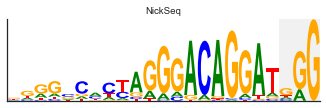

In [47]:
plotSequenceLogo(ppm, title = 'NickSeq')
#plotSequenceLogo(ppm, hitsBOOT, title = 'NickSeq')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6E_nickseq.pdf', bbox_inches = 'tight', transparent = 'True')

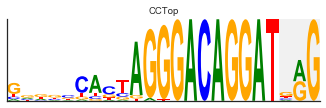

In [48]:
plotSequenceLogo(ppmCCTOP, title = 'CCTop')
#plotSequenceLogo(ppmCCTOP, cctopBOOT, title = 'CCTop')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6E_cctop.pdf', bbox_inches = 'tight', transparent = 'True')

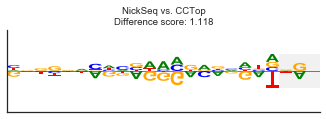

In [49]:
plotDiffLogo(ppm, ppmCCTOP, title = 'NickSeq vs. CCTop')
#plotDiffLogo(ppm, ppmCCTOP, [None, cctopBOOT], 'NickSeq vs. CCTop')
#plotDiffLogo(ppm, ppmCCTOP, [hitsBOOT, None], 'NickSeq vs. CCTop')
#plotDiffLogo(ppm, ppmCCTOP, [hitsBOOT, cctopBOOT], 'NickSeq vs. CCTop')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6E_nickseq_cctop.pdf', bbox_inches = 'tight', transparent = 'True')

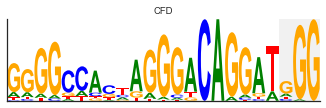

In [50]:
plotSequenceLogo(ppmCFD, title = 'CFD')
#plotSequenceLogo(ppmCFD, cfdBOOT, 'CFD')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6E_cfd.pdf', bbox_inches = 'tight', transparent = 'True')

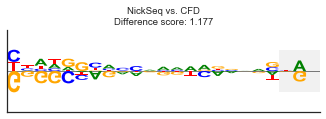

In [51]:
plotDiffLogo(ppm, ppmCFD, title = 'NickSeq vs. CFD')
#plotDiffLogo(ppm, ppmCFD, [None, cfdBOOT], 'NickSeq vs. CFD')
#plotDiffLogo(ppm, ppmCFD, [hitsBOOT, None], 'NickSeq vs. CFD')
#plotDiffLogo(ppm, ppmCFD, [hitsBOOT, cfdBOOT], 'NickSeq vs. CFD')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6E_nickseq_cfd.pdf', bbox_inches = 'tight', transparent = 'True')

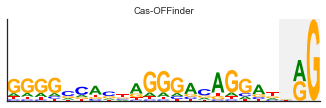

In [52]:
plotSequenceLogo(ppmCasOFF, title = 'Cas-OFFinder')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6E_casoff.pdf', bbox_inches = 'tight', transparent = 'True')

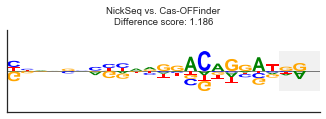

In [53]:
plotDiffLogo(ppm, ppmCasOFF, title = 'NickSeq vs. Cas-OFFinder')
#plotDiffLogo(ppm, ppmCasOFF, [hitsBOOT, None], 'NickSeq vs. Cas-OFFinder')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6E_nickseq_casoff.pdf', bbox_inches = 'tight', transparent = 'True')

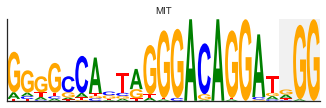

In [54]:
plotSequenceLogo(ppmMIT, title = 'MIT')
#plotSequenceLogo(ppmMIT, mitBOOT, 'MIT')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6E_mit.pdf', bbox_inches = 'tight', transparent = 'True')

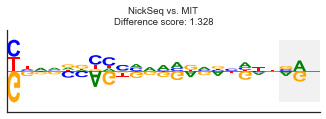

In [55]:
plotDiffLogo(ppm, ppmMIT, title = 'NickSeq vs. MIT')
#plotDiffLogo(ppm, ppmMIT, [None, mitBOOT], 'NickSeq vs. MIT')
#plotDiffLogo(ppm, ppmMIT, [hitsBOOT, None], 'NickSeq vs. MIT')
#plotDiffLogo(ppm, ppmMIT, [hitsBOOT, mitBOOT], 'NickSeq vs. MIT')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6E_nickseq_mit.pdf', bbox_inches = 'tight', transparent = 'True')

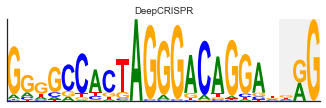

In [56]:
plotSequenceLogo(ppmDEEP, title = 'DeepCRISPR')
#plotSequenceLogo(ppmDEEP, deepBOOT, 'DeepCRISPR')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6E_deep.pdf', bbox_inches = 'tight', transparent = 'True')

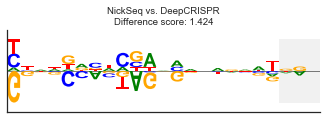

In [57]:
plotDiffLogo(ppm, ppmDEEP, title = 'NickSeq vs. DeepCRISPR')
#plotDiffLogo(ppm, ppmDEEP, [None, deepBOOT], 'NickSeq vs. DeepCRISPR')
#plotDiffLogo(ppm, ppmDEEP, [hitsBOOT, None], 'NickSeq vs. DeepCRISPR')
#plotDiffLogo(ppm, ppmDEEP, [hitsBOOT, deepBOOT], 'NickSeq vs. DeepCRISPR')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6E_nickseq_deep.pdf', bbox_inches = 'tight', transparent = 'True')

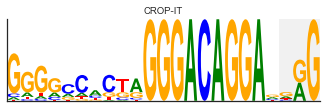

In [58]:
plotSequenceLogo(ppmCROPIT, title = 'CROP-IT')
#plotSequenceLogo(ppmCROPIT, cropitBOOT, 'CROP-IT')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6E_cropit.pdf', bbox_inches = 'tight', transparent = 'True')

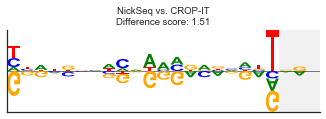

In [59]:
plotDiffLogo(ppm, ppmCROPIT, title = 'NickSeq vs. CROP-IT')
#plotDiffLogo(ppm, ppmCROPIT, [None, cropitBOOT], 'NickSeq vs. CROP-IT')
#plotDiffLogo(ppm, ppmCROPIT, [hitsBOOT, None], 'NickSeq vs. CROP-IT')
#plotDiffLogo(ppm, ppmCROPIT, [hitsBOOT, cropitBOOT], 'NickSeq vs. CROP-IT')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6E_nickseq_cropit.pdf', bbox_inches = 'tight', transparent = 'True')

### Figure S1

In [34]:
enzymes = ['taq', 'therminator', 'sulfolobusPolIV']
dKTP = countOligoBases([data_dir + 'figS1/oligo_dPTP_dKTP_' + i + 'Extension_R1.fastq.gz' for i in enzymes], 62, 11, True)
dRTP = countOligoBases([data_dir + 'figS1/oligo_dPTP_dRTP_' + i + 'Extension_R1.fastq.gz' for i in enzymes], 62, 11, True)
seq = 'TGAGTCACTTG'

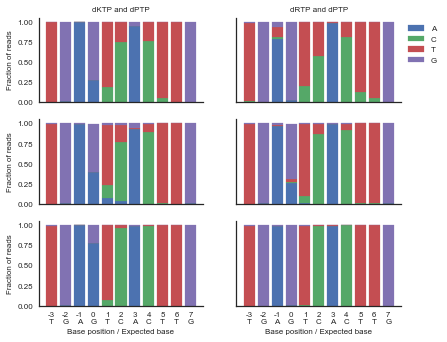

In [35]:
plotOligo([dKTP, dRTP], ['dKTP and dPTP', 'dRTP and dPTP'], figsize = (6.5, 5.3))
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S1.pdf', bbox_inches = 'tight', transparent = 'True')

### Figure S2

In [36]:
taqBases, taqCov = getData(data_dir + 'figS2/plasmid_taqExtension', 'plasmid_pilon', ['.sorted.bam', '.sorted.bam'])
taqBases = taqBases[0]
polIBases, polICov = getData(data_dir + 'figS2/plasmid_polIExtension', 'plasmid_pilon', ['.sorted.bam', '.sorted.bam'])
polIBases = polIBases[0]

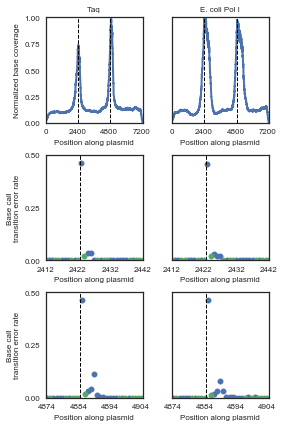

In [37]:
plt.figure(figsize = (4, 7))

coverage = [taqCov, polICov]
bases = [taqBases, polIBases]
enzymes = ['Taq', 'E. coli Pol I']

plasmidReference = readReference(data_dir + 'fig3/pilon_psrM01.fasta', 'plasmid_pilon')
transition = baseTransitions(plasmidReference)
p = [i in 'CT' for i in plasmidReference]
k = [i in 'AG' for i in plasmidReference]

for i in range(2):
    plt.subplot(3, 2, i + 1)
    plt.plot(range(len(coverage[i])), coverage[i] / max(coverage[i]))
    plt.ylim((0, 1))
    plt.xlim((0, 7305))
    plt.xticks([0, 2400, 4800, 7200])
    plt.xlabel('Position along plasmid')
    if i == 0:
        plt.ylabel('Normalized base coverage')
        plt.yticks([0, 0.25, 0.5, 0.75, 1])
    else:
        plt.yticks([])
    plt.title(enzymes[i], fontsize = 8)
    plt.axvline(2422, lw = 1, ls = 'dashed', color = 'black')
    plt.axvline(4884, lw = 1, ls = 'dashed', color = 'black')
    
    plt.subplot(3, 2, i + 3)
    plt.scatter([j for j in range(2412, 2443) if p[j]], [bases[i][j][transition[j]] for j in range(2412, 2443) if p[j]])
    plt.scatter([j for j in range(2412, 2443) if k[j]], [bases[i][j][transition[j]] for j in range(2412, 2443) if k[j]])
    plt.ylim((0, 0.5))
    plt.xlim((2412, 2442))
    plt.xticks([2412, 2422, 2432, 2442])
    plt.xlabel('Position along plasmid')
    if i == 0:
        plt.ylabel('Base call\ntransition error rate')
        plt.yticks([0, 0.25, 0.5])
    else:
        plt.yticks([])
    plt.axvline(2422.5, ls = 'dashed', color = 'black', lw = 1)
               
    plt.subplot(3, 2, i + 5)
    plt.scatter([j for j in range(4873, 4905) if p[j]], [bases[i][j][transition[j]] for j in range(4873, 4905) if p[j]])
    plt.scatter([j for j in range(4873, 4905) if k[j]], [bases[i][j][transition[j]] for j in range(4873, 4905) if k[j]])
    plt.ylim((0, 0.5))
    plt.xlim([4873.5, 4904.5])
    plt.xticks([4874, 4884, 4894, 4904])
    plt.xlabel('Position along plasmid')
    if i == 0:
        plt.ylabel('Base call\ntransition error rate')
        plt.yticks([0, 0.25, 0.5])
    else:
        plt.yticks([])
    plt.axvline(4884.5, ls = 'dashed', color = 'black', lw = 1)
    
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S2.pdf', bbox_inches = 'tight', transparent = 'True')

### Figure S3

In [38]:
files = ['taq', 'ventExo', 'NEBnext', 'kapa']
bases = []
coverage = []
for file in files:
    b, c = getData(data_dir + 'figS3/plasmid_' + file + 'PCR', 'plasmid_pilon', ['.sorted.bam', '.sorted.bam'])
    bases.append(b[0])
    coverage.append(c)

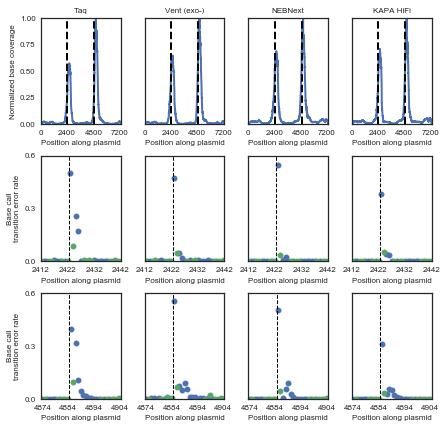

In [39]:
enzymes = ['Taq', 'Vent (exo-)', 'NEBNext', 'KAPA HiFi']
plt.figure(figsize = (7, 7))

for i in range(4):
    plt.subplot(3, 4, i + 1)
    plt.plot(range(len(coverage[i])), coverage[i] / max(coverage[i]))
    plt.ylim((0, 1))
    plt.xlim((0, 7305))
    plt.xticks([0, 2400, 4800, 7200])
    plt.xlabel('Position along plasmid')
    if i == 0:
        plt.ylabel('Normalized base coverage')
        plt.yticks([0, 0.25, 0.5, 0.75, 1])
    else:
        plt.yticks([])
    plt.title(enzymes[i], fontsize = 8)
    plt.axvline(2422, ls = 'dashed', color = 'black')
    plt.axvline(4884, ls = 'dashed', color = 'black')
    
    plt.subplot(3, 4, i + 5)
    plt.scatter([j for j in range(2412, 2443) if p[j]], [bases[i][j][transition[j]] for j in range(2412, 2443) if p[j]])
    plt.scatter([j for j in range(2412, 2443) if k[j]], [bases[i][j][transition[j]] for j in range(2412, 2443) if k[j]])
    plt.ylim((0, 0.6))
    plt.xlim((2412, 2442))
    plt.xticks([2412, 2422, 2432, 2442])
    plt.xlabel('Position along plasmid')
    if i == 0:
        plt.ylabel('Base call\ntransition error rate')
        plt.yticks([0, 0.3, 0.6])
    else:
        plt.yticks([])
    plt.axvline(2422.5, ls = 'dashed', color = 'black', lw = 1)
               
    plt.subplot(3, 4, i + 9)
    plt.scatter([j for j in range(4873, 4905) if p[j]], [bases[i][j][transition[j]] for j in range(4873, 4905) if p[j]])
    plt.scatter([j for j in range(4873, 4905) if k[j]], [bases[i][j][transition[j]] for j in range(4873, 4905) if k[j]])
    plt.ylim((0, 0.6))
    plt.xlim([4873.5, 4904.5])
    plt.xticks([4874, 4884, 4894, 4904])
    plt.xlabel('Position along plasmid')
    if i == 0:
        plt.ylabel('Base call\ntransition error rate')
        plt.yticks([0, 0.3, 0.6])
    else:
        plt.yticks([])
    plt.axvline(4884.5, ls = 'dashed', color = 'black', lw = 1)
    
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S3.pdf', bbox_inches = 'tight', transparent = 'True')

### Figure S4

In [40]:
desthioCpull = countCoverage(data_dir + 'figS4/plasmid_desthiobiotindCTP_pulldown.sorted.bam', 'plasmid_pilon')
desthioCelu = countCoverage(data_dir + 'figS4/plasmid_desthiobiotindCTP_pulldownAndElution.sorted.bam', 'plasmid_pilon')
biotinPull_C = countCoverage(data_dir + 'figS4/plasmid_DTBdCTPcomparison_biotindUTP_pulldown.sorted.bam', 'plasmid_pilon')

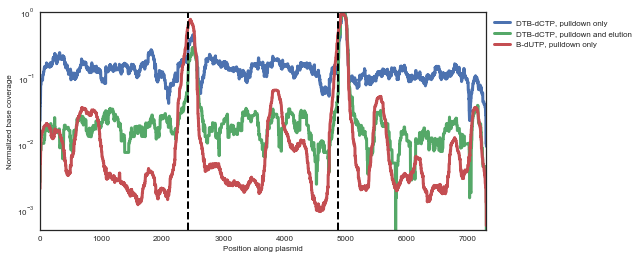

In [41]:
plt.figure(figsize = (8, 4))

for cov in [desthioCpull, desthioCelu, biotinPull_C]:
    plt.plot(range(len(cov)), cov / max(cov), lw = 3)
plt.xlabel('Position along plasmid')
plt.ylim([0.0005, 1])
plt.yscale('log')
plt.ylabel('Normalized base coverage')
plt.legend(('DTB-dCTP, pulldown only', 'DTB-dCTP, pulldown and elution', 'B-dUTP, pulldown only'), loc = "upper left", bbox_to_anchor = (1, 1), markerscale = 2)
plt.axvline(2422, c = 'black', ls = 'dashed', ymin = 0)
plt.axvline(4884, c = 'black', ls = 'dashed', ymin = 0)
plt.xlim(0, 7305)

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S4A.pdf', bbox_inches = 'tight', transparent = 'True')

In [42]:
desthioApull = countCoverage(data_dir + 'figS4/plasmid_desthiobiotindATP_pulldown.sorted.bam', 'plasmid_pilon')
desthioAelu = countCoverage(data_dir + 'figS4/plasmid_desthiobiotindATP_pulldownAndElution.sorted.bam', 'plasmid_pilon')
biotinPull_A = countCoverage(data_dir + 'figS4/plasmid_DTBdATPcomparison_biotindUTP_pulldown.sorted.bam', 'plasmid_pilon')

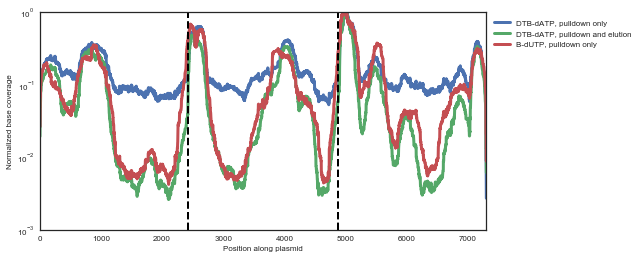

In [43]:
plt.figure(figsize = (8, 4))

for cov in [desthioApull, desthioAelu, biotinPull_A]:
    plt.plot(range(len(cov)), cov / max(cov), lw = 3)
plt.xlabel('Position along plasmid')
plt.ylim([0.001, 1])
plt.yscale('log')
plt.ylabel('Normalized base coverage')
plt.legend(('DTB-dATP, pulldown only', 'DTB-dATP, pulldown and elution', 'B-dUTP, pulldown only'), loc = "upper left", bbox_to_anchor = (1, 1), markerscale = 2)
plt.axvline(2422, c = 'black', ls = 'dashed', ymin = 0)
plt.axvline(4884, c = 'black', ls = 'dashed', ymin = 0)
plt.xlim(0, 7305)

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S4B.pdf', bbox_inches = 'tight', transparent = 'True')

### Figure S5

In [44]:
x4 = countCoverage(data_dir + 'figS5/plasmid_4xdNTP.noDup.bam', 'plasmid_pilon')
x2 = countCoverage(data_dir + 'figS5/plasmid_2xdNTP.noDup.bam', 'plasmid_pilon')
x1 = countCoverage(data_dir + 'fig3/plasmid_NbBsmI.noDup.bam', 'plasmid_pilon')

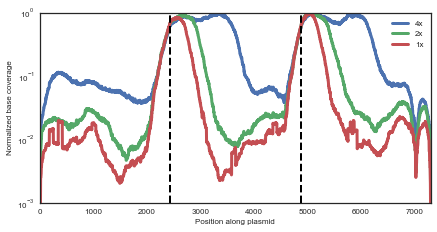

In [45]:
plt.figure(figsize = (7, 3.5))

for c in [x4, x2, x1]:
    plt.plot(range(len(c)), c / max(c), lw = 3)

plt.ylim([0.001, 1])
plt.xlim([0, 7305])

plt.axvline(2422, c = 'black', ls = 'dashed')
plt.axvline(4884, c = 'black', ls = 'dashed')

plt.yscale('log')

plt.ylabel('Normalized base coverage')
plt.xlabel('Position along plasmid')
plt.legend(['4x', '2x', '1x'], markerscale = 2)

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S5.pdf', bbox_inches = 'tight', transparent = 'True')

### Figure S6

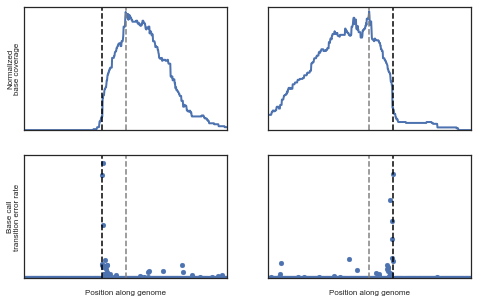

In [46]:
# must run code for fig 5 first

m = max(genomeCov)

plt.figure(figsize = (8, 5))

count = 0
count2 = 0
for _, peak in peaks[peaks.nicksContained > 0].iterrows():
    if calledNicks[count] in range(peak.start, peak.end):
        if count in [2, 6]:
            plt.subplot(2, 2, count2 + 1)
            plt.xticks([])
            plt.yticks([])
            ind = peak.start + np.argmax(genomeCov[peak.start:peak.end + 1])
            ind2 = 300
            plt.ylim(0, genomeCov[ind] / m + 0.025)
            plt.xlim([ind - ind2, ind + ind2])
            plt.plot(range(ind - ind2, ind + ind2 + 1), genomeCov[ind - ind2:ind + ind2 + 1] / m)
            if count2 == 0:
                plt.ylabel('Normalized\nbase coverage')
            plt.axvline(calledNicks[count], ls = 'dashed', color = 'black', lw = 1.5)
            plt.axvline(ind, ls = 'dashed', color = 'gray', lw = 1.5)

            plt.subplot(2, 2, count2 + 3)
            plt.xlim([ind - ind2, ind + ind2])
            transition = baseTransitions(genomeReference[ind - ind2:ind + ind2 + 1])
            toPlot = np.array([genomeBases[i + ind - ind2][transition[i]] for i in range(len(transition))])
            toPlot[np.isnan(toPlot)] = 0
            plt.scatter(range(ind - ind2, ind + ind2 + 1), toPlot, s = 24)
            if count2 == 0:
                plt.ylabel('Base call\ntransition error rate')
            plt.yticks([])
            plt.xlabel('\nPosition along genome')
            plt.xticks([])
            plt.ylim(0, 0.3)
            plt.axvline(calledNicks[count], ls = 'dashed', color = 'black', lw = 1.5)
            plt.axvline(ind, ls = 'dashed', color = 'gray', lw = 1.5)
            count2 += 1

        count += 1
        if count == 1 or count == 4:
            count += 1
        if count == len(calledNicks):
            break

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S6.pdf', bbox_inches = 'tight', transparent = 'True')

### Figure S7

In [47]:
plasmidReference = readReference('../../../paper/data/fig3/pilon_psrM01.fasta', 'plasmid_pilon')
plasmidReference2 = readReference('../../../paper/data/fig4/pMN00_targetInsertAAVS1.fasta', 'pMN00_target')
p = [i in 'CT' for i in plasmidReference]
k = [i in 'AG' for i in plasmidReference]

In [48]:
files = ['100', '10', '1', '0_1', '0_01']
dilutionPeaks = [[] for _ in range(5)]
for i in range(5):
    #os.system('macs2 callpeak -t ' + data_dir + 'figS7/plasmid_nick' + files[i] + 'p.rmDup.bam -g ' + str(len(plasmidReference2) + (10 ** i - 1) * len(plasmidReference)) + ' --nomodel -n ' + data_dir + 'figS7/plasmid_nick' + files[i] + 'p')
    dilutionPeaks[i] = loadPeaks(data_dir + 'figS7/plasmid_nick' + files[i] + 'p_peaks.xls')
        
dilutionPeak1 = [1142, 1142]
dilutionPeak2 = [4010, 4010]
for dilPeak in dilutionPeaks:
    temp = dilPeak[(dilPeak.chromosome == 'pMN00_target') & (dilPeak.logQ > 6)]
    if not temp.empty:
        dilutionPeak1 = [min(dilutionPeak1[0], temp.loc[0, 'start']), max(dilutionPeak1[1], temp.loc[0, 'end'])]
        dilutionPeak2 = [min(dilutionPeak2[0], temp.loc[1, 'start']), max(dilutionPeak2[1], temp.loc[1, 'end'])]

In [49]:
def readInPeak(read, p1, p2):
    if (read.reference_start <= p1[1] or read.next_reference_start <= p1[1]) and (read.reference_end >= p1[0] or read.next_reference_start + len(read.query_sequence) >= p1[0]):
        return 1
    elif (read.reference_start <= p2[1] or read.next_reference_start <= p2[1]) and (read.reference_end >= p2[0] or read.next_reference_start + len(read.query_sequence) >= p2[0]):
        return 2
    else:
        return 0

peak1ReadCounts = [0] * 5
peak2ReadCounts = [0] * 5
totalReadCounts = [0] * 5
plasmid1GoodCov = [np.array([0] * len(plasmidReference2)) for _ in range(5)]
plasmid1BadCov = [np.array([0] * len(plasmidReference2)) for _ in range(5)]
plasmid2Cov = [np.array([0] * len(plasmidReference)) for _ in range(5)]
insertLength = []
for i in range(5):
    samfile = pysam.AlignmentFile(data_dir + 'figS7/plasmid_nick' + files[i] + 'p.rmDup.bam')
    for read in samfile.fetch('pMN00_target'):
        if read.is_proper_pair and read.mapping_quality >= 30:
            start = read.reference_start
            mateStart = read.next_reference_start
            if start > mateStart or (start == mateStart and read.mate_is_reverse):
                stop = read.reference_end
                whichPeak = readInPeak(read, dilutionPeak1, dilutionPeak2) 
                if whichPeak:
                    plasmid1GoodCov[i][mateStart:stop] += 1
                    if whichPeak == 1:
                        peak1ReadCounts[i] += 1
                    else:
                        peak2ReadCounts[i] += 1
                else:
                    plasmid1BadCov[i][mateStart:stop] += 1
                totalReadCounts[i] += 1
                insertLength.append(stop - mateStart)
    for read in samfile.fetch('plasmid_pilon'):
        if read.is_proper_pair and read.mapping_quality >= 30:
            start = read.reference_start
            mateStart = read.next_reference_start
            if start > mateStart or (start == mateStart and read.mate_is_reverse):
                stop = read.reference_end
                plasmid2Cov[i][mateStart:stop] += 1
                totalReadCounts[i] += 1
                insertLength.append(stop - mateStart)
    samfile.close()
insertLength = int(round(np.mean(insertLength)))

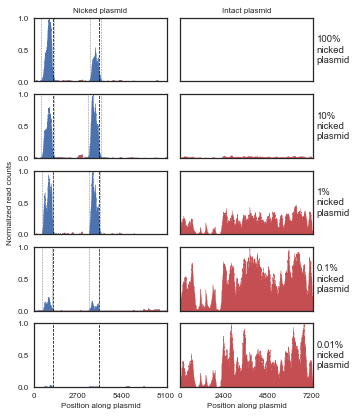

In [50]:
qThreshold = 6
            
plt.figure(figsize = (5, 11))
for i in range(5):
    yLimit = max(np.concatenate([plasmid1GoodCov[i] + plasmid1BadCov[i], plasmid2Cov[i]]))
    plt.subplot(8, 2, 2 * i + 1)
    plt.fill_between(range(len(plasmidReference2)), (plasmid1GoodCov[i] + plasmid1BadCov[i]) / yLimit, color = blue)
    plt.fill_between(range(len(plasmidReference2)), plasmid1BadCov[i] / yLimit, color = red)
    plt.axvline(1141.5, c = 'k', ls = 'dashed', lw = 0.75)
    plt.axvline(4009.5, c = 'k', ls = 'dashed', lw = 0.75)
    for _, dilPeak in dilutionPeaks[i][(dilutionPeaks[i].chromosome == 'pMN00_target') & (dilutionPeaks[i].logQ >= qThreshold)].iterrows():
        plt.axvline(dilPeak.start, c = 'gray', ls = 'dashed', lw = 0.5)
        plt.axvline(dilPeak.end, c = 'gray', ls = 'dashed', lw = 0.5)
    plt.xlim(0, len(plasmidReference2))
    plt.ylim(0, 1)
    plt.yticks([0, 0.5, 1])
    if i < 4:
        plt.xticks([])
        if i == 2:
            plt.ylabel('Normalized read counts')
        elif i == 0:
            plt.title('Nicked plasmid', fontsize = 8)
    else:
        plt.xlabel('Position along plasmid')
        plt.xticks([0, 2700, 5400, 8100])

    plt.subplot(8, 2, 2 * i + 2)
    plt.fill_between(range(len(plasmidReference)), plasmid2Cov[i] / yLimit, color = red)
    plt.xlim(0, len(plasmidReference))
    plt.ylim(0, 1)
    plt.yticks([])
    if i < 4:
        plt.xticks([])
        if i == 0:
            plt.title('Intact plasmid', fontsize = 8)
    else:
        plt.xlabel('Position along plasmid')
        plt.xticks([0, 2400, 4800, 7200])
    plt.text(7500, 0.3, files[i].replace('_', '.') + '%\nnicked\nplasmid')
        
plt.subplots_adjust(hspace = 0.2, wspace = 0.1)

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S7A.pdf', bbox_inches = 'tight', transparent = 'True')

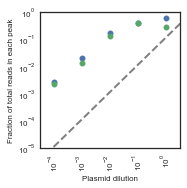

In [51]:
fractionExpectedInPeaks = (dilutionPeak1[1] - dilutionPeak1[0] + dilutionPeak2[1] - dilutionPeak2[0] + insertLength * 2 + 2) / (len(plasmidReference2) - insertLength)

plt.figure(figsize = (2.5, 2.5))

plt.scatter([10 ** -i for i in range(5)], [peak1ReadCounts[i] / totalReadCounts[i] for i in range(5)], c = [blue])
plt.scatter([10 ** -i for i in range(5)], [peak2ReadCounts[i] / totalReadCounts[i] for i in range(5)], c = [green])
plotLine = np.array([0.00005, 5])
plt.plot(plotLine, plotLine / 2 * fractionExpectedInPeaks, ls = 'dashed', c = 'gray')
plt.xlabel('Plasmid dilution')
plt.ylabel("Fraction of total reads in each peak")
plt.xscale('log')
plt.yscale('log')
plt.ylim([0.00001, 1])
plt.xlim([0.000031623, 3.1623])
plt.xticks([10 ** i for i in range(-4, 1)], rotation = 'vertical')

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S7B.pdf', bbox_inches = 'tight', transparent = 'True')

In [52]:
positiveControl = pysam.AlignmentFile(data_dir + 'fig3/plasmid_NbBsmI.noDup.bam')
negativeControl = pysam.AlignmentFile(data_dir + 'fig3/plasmid_noNicks.noDup.bam')

posPeaks = loadPeaks(data_dir + 'fig3/plasmid_NbBsmI_peaks.xls')
peak1 = list(posPeaks.loc[0, ['start', 'end']])
peak2 = list(posPeaks.loc[1, ['start', 'end']])

maxReadsPeak1 = 0
maxReadsPeak2 = 0
for read in positiveControl.fetch('plasmid_pilon'):
    if read.is_proper_pair and read.mapping_quality >= 30:
        temp = readInPeak(read, peak1, peak2)
        if temp == 1:
            maxReadsPeak1 += 1
        elif temp == 2:
            maxReadsPeak2 += 1
maxReadsOff = negativeControl.mapped

maxReadsPeak1 /= 2
maxReadsPeak2 /= 2
maxReadsOff /= 2

In [53]:
onCount = [0] * 5
offCount = [0] * 5
onCov = [np.array([0] * 7305) for _ in range(5)]
onLocs = [[[] for _ in range(7305)] for _ in range(5)]
offCov = [np.array([0] * 7305) for _ in range(5)]
offLocs = [[[] for _ in range(7305)] for _ in range(6)]
if not os.path.exists(figurePrint_dir + 'temp/'):
    os.mkdir(saveDir + 'temp/')
for i in range(5):
    p1 = peak1ReadCounts[i]
    p2 = peak2ReadCounts[i]
    t = totalReadCounts[i]
    maxReads = math.floor(min([(maxReadsPeak1 + maxReadsPeak2) / ((p1 + p2) / t), maxReadsOff / ((t - p1 - p2) / t)]))
    
    p1NumReads = round(maxReads * (p1 + p2) / t * maxReadsPeak1 / (maxReadsPeak1 + maxReadsPeak2))
    p2NumReads = round(maxReads * (p1 + p2) / t * maxReadsPeak2 / (maxReadsPeak1 + maxReadsPeak2))
    offNumReads = round(maxReads * (t - p1 - p2) / t)
    
    p1Reads = sorted(random.sample(range(int(maxReadsPeak1)), p1NumReads))
    p2Reads = sorted(random.sample(range(int(maxReadsPeak2)), p2NumReads))
    onReadNames = []
    offReads = sorted(random.sample(range(int(maxReadsOff)), offNumReads))
    offReadNames = []
    
    p1Index = 0
    p1Loc = 0
    p2Index = 0
    p2Loc = 0
    for read in positiveControl.fetch('plasmid_pilon'):
        if read.is_proper_pair and read.mapping_quality >= 30 and (read.reference_start > read.next_reference_start or (read.reference_start == read.next_reference_start and read.mate_is_reverse)):
            whichPeak = readInPeak(read, peak1, peak2)
            if whichPeak == 1:
                if p1Index < len(p1Reads) and p1Reads[p1Index] == p1Loc:
                    onCov[i][read.next_reference_start:read.reference_end] += 1
                    onLocs[i][read.next_reference_start].append(read.reference_start)
                    p1Index += 1
                    onCount[i] += 1
                    onReadNames.append(read.query_name)
                p1Loc += 1
            elif whichPeak == 2:
                if p2Index < len(p2Reads) and p2Reads[p2Index] == p2Loc:
                    onCov[i][read.next_reference_start:read.reference_end] += 1
                    onLocs[i][read.next_reference_start].append(read.reference_start)
                    p2Index += 1
                    onCount[i] += 1
                    onReadNames.append(read.query_name)
                p2Loc += 1
    
    offIndex = 0
    offLoc = 0
    for read in negativeControl.fetch('plasmid_pilon'):
        if read.is_proper_pair and read.mapping_quality >= 30 and (read.reference_start > read.next_reference_start or (read.reference_start == read.next_reference_start and read.mate_is_reverse)):
            if offIndex < len(offReads) and offReads[offIndex] == offLoc:
                offCov[i][read.next_reference_start:read.reference_end] += 1
                offLocs[i][read.next_reference_start].append(read.reference_start)
                offIndex += 1
                offCount[i] += 1
                offReadNames.append(read.query_name)
            offLoc += 1
    
    #fileName = data_dir + 'figS7/temp/diluted_1e-' + str(i) + '.noDup.bam'
    #writeFile = pysam.AlignmentFile(fileName, 'wb', template = samfile)
    #for read in onTargetReads.fetch('plasmid_pilon'):
    #    if read.query_name in onReadNames:
    #        writeFile.write(read)
    #for read in offTargetReads.fetch('plasmid_pilon'):
    #    if read.query_name in offReadNames:
    #        writeFile.write(read)
    #writeFile.close()
    #os.system('macs2 callpeak -t ' + fileName + ' -f BAMPE --keep-dup all -g 7305 --nomodel -n ' + fileName[:-10])

negCov = np.array([0] * 7305)
for read in negativeControl.fetch('plasmid_pilon'):
    if read.is_proper_pair and read.mapping_quality >= 30 and (read.reference_start > read.next_reference_start or (read.reference_start == read.next_reference_start and read.mate_is_reverse)):
        negCov[read.next_reference_start:read.reference_end] += 1
        offLocs[5][read.next_reference_start].append(read.reference_start)
#os.system('macs2 callpeak -t ' + data_dir + 'fig3/plasmid_noNicks.noDup.bam -f BAMPE --keep-dup all -g 7305 --nomodel -n ' + data_dir + 'figS7/temp/neg')

positiveControl.close()
negativeControl.close()

In [54]:
def readsToBaseCalls(reads, cigars, qualities, startIndices):
    fixedReads = []
    for j in range(len(reads)):
        # delete base calls with low quality score
        qual = np.array([int(x) for x in qualities[j][1:-1].split(', ')])
        temp = np.array(list(reads[j]))
        temp[qual < 30] = 'N'
        # deal with indels in read
        ind = 0
        read = np.array([])
        cigarType = re.findall('[MDI]', cigars[j])
        cigarLength = [int(x) for x in re.split('[MDI]', cigars[j])[:-1]]
        for x in range(len(cigarType)):
            if cigarType[x] == 'M':
                read = np.concatenate([read, temp[ind:ind + cigarLength[x]]])
                ind += cigarLength[x]
            elif cigarType[x] == 'D':
                read = np.concatenate([read, ['N'] * cigarLength[x]])
            else:
                ind += cigarLength[x]
        fixedReads.append(read)
    
    baseCallsA = np.array([0] * 7305)
    baseCallsC = np.array([0] * 7305)
    baseCallsG = np.array([0] * 7305)
    baseCallsT = np.array([0] * 7305)
    for j in range(len(fixedReads)):
        baseCallsA[startIndices[j] + np.where(fixedReads[j] == 'A')[0]] += 1
        baseCallsC[startIndices[j] + np.where(fixedReads[j] == 'C')[0]] += 1
        baseCallsG[startIndices[j] + np.where(fixedReads[j] == 'G')[0]] += 1
        baseCallsT[startIndices[j] + np.where(fixedReads[j] == 'T')[0]] += 1
        
    c = (baseCallsA, baseCallsC, baseCallsG, baseCallsT)
    cov = pd.DataFrame()
    for j in index:
        cov = pd.concat([cov, pd.DataFrame(c[j].tolist()).T])
    cov.index = index2
    readCount = cov.sum(axis = 0)
    return cov / readCount, readCount

positiveControl = pysam.AlignmentFile(data_dir + 'fig3/plasmid_NbBsmI.sorted.bam')
negativeControl = pysam.AlignmentFile(data_dir + 'fig3/plasmid_noNicks.sorted.bam')

bases = [[] for _ in range(6)]
rc = [[] for _ in range(6)]
for i in range(5):
    numOnReads = 0
    numOffReads = 0
    for read in positiveControl.fetch('plasmid_pilon'):
        if read.is_proper_pair and read.reference_start in onLocs[i][read.next_reference_start]:
            numOnReads += 1
            # don't double count read pairs that start at the same location
            if read.reference_start == read.next_reference_start:
                numOnReads -= 0.5
    for read in negativeControl.fetch('plasmid_pilon'):
        if read.is_proper_pair and read.reference_start in offLocs[i][read.next_reference_start]:
            numOffReads += 1
            # don't double count read pairs that start at the same location
            if read.reference_start == read.next_reference_start:
                numOffReads -= 0.5
    
    onDuplicationRate = numOnReads / onCount[i]
    offDuplicationRate = numOffReads / offCount[i]
    if offDuplicationRate > onDuplicationRate:
        raise Exception('Unexpected: off-target read duplication rate exceeds on-target read duplication rate')
    keep = sorted(random.sample(range(int(numOnReads)), round(offDuplicationRate / onDuplicationRate * float(numOnReads))))
        
    loc = 0
    ind = 0
    onReadNames = [[] for _ in range(7305)]
    for read in positiveControl.fetch('plasmid_pilon'):
        if read.is_proper_pair and read.reference_start in onLocs[i][read.next_reference_start] and (read.reference_start != read.next_reference_start or read.mate_is_reverse):
            if ind < len(keep) and keep[ind] == loc:
                onReadNames[read.reference_start].append(read.query_name)
                ind += 1
            loc += 1
    
    reads = []
    cigars = []
    qualities = []
    startIndices = []
    for read in positiveControl.fetch('plasmid_pilon'):
        if read.is_proper_pair and (read.query_name in onReadNames[read.reference_start] or read.query_name in onReadNames[read.next_reference_start]):
            temp = str(read).split('\t')
            reads.append(temp[9])
            cigars.append(temp[5])
            qualities.append(temp[10][11:-1])
            startIndices.append(int(temp[3]))
    for read in negativeControl.fetch('plasmid_pilon'):
        if read.is_proper_pair and (read.reference_start in offLocs[i][read.next_reference_start] or read.next_reference_start in offLocs[i][read.reference_start]):
            temp = str(read).split('\t')
            reads.append(temp[9])
            cigars.append(temp[5])
            qualities.append(temp[10][11:-1])
            startIndices.append(int(temp[3]))
    bases[i], rc[i] = readsToBaseCalls(reads, cigars, qualities, startIndices)
    
positiveControl.close()

reads = []
cigars = []
qualities = []
startIndices = []
for read in negativeControl.fetch('plasmid_pilon'):
    if read.is_proper_pair and (read.reference_start in offLocs[5][read.next_reference_start] or read.next_reference_start in offLocs[5][read.reference_start]):
        temp = str(read).split('\t')
        reads.append(temp[9])
        cigars.append(temp[5])
        qualities.append(temp[10][11:-1])
        startIndices.append(int(temp[3]))
bases[5], rc[5] = readsToBaseCalls(reads, cigars, qualities, startIndices)

negativeControl.close()

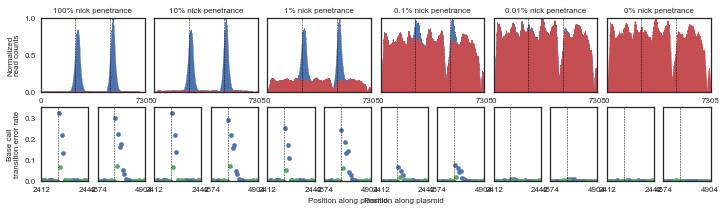

In [55]:
transition = baseTransitions(plasmidReference)

plt.figure(figsize = (12, 3))
grid = plt.GridSpec(2, 12)
for i in range(6):
    plt.subplot(grid[0, 2 * i:2 * i + 2])
    if i == 5:
        plt.title('0% nick penetrance', fontsize = 8)
        plt.fill_between(range(len(plasmidReference)), negCov / max(negCov), color = red)
    else:
        plt.title(files[i].replace('_', '.') + '% nick penetrance', fontsize = 8)
        m = max(onCov[i] + offCov[i])
        plt.fill_between(range(len(plasmidReference)), (onCov[i] + offCov[i]) / m, offCov[i] / m, color = blue)
        plt.fill_between(range(len(plasmidReference)), offCov[i] / m, color = red)
    plt.xlim(0, len(plasmidReference))
    plt.ylim(0, 1)
    plt.axvline(2422.5, c = 'k', ls = 'dashed', lw = 0.5)
    plt.axvline(4884.5, c = 'k', ls = 'dashed', lw = 0.5)
    plt.xticks([0, len(plasmidReference)])
    if i == 0:
        plt.ylabel('Normalized\nread counts')
        plt.yticks([0, 0.5, 1])
    else:
        plt.yticks([])
    
    plt.subplot(grid[1, 2 * i])
    y = [bases[i][j][transition[j]] for j in range(len(plasmidReference))]
    plt.scatter([j for j in range(2412, 2443) if p[j]], [y[j] for j in range(2412, 2443) if p[j]], s = 20)
    plt.scatter([j for j in range(2412, 2443) if k[j]], [y[j] for j in range(2412, 2443) if k[j]], s = 20)
    if i == 0:
        plt.ylabel('Base call\ntransition error rate')
        plt.yticks([0, 0.1, 0.2, 0.3])
    else:
        plt.yticks([])
    plt.ylim(0, 0.35)
    plt.xlim(2411.5, 2442.5)
    plt.axvline(2422.5, c = 'k', ls = 'dashed', lw = 0.5)
    plt.xticks([2412, 2442])
    if i == 3:
        plt.xlabel('Position along plasmid')
    
    plt.subplot(grid[1, 2 * i + 1])
    plt.scatter([j for j in range(4874, 4905) if p[j]], [y[j] for j in range(4874, 4905) if p[j]], s = 20)
    plt.scatter([j for j in range(4874, 4905) if k[j]], [y[j] for j in range(4874, 4905) if k[j]], s = 20)
    plt.yticks([])
    plt.ylim(0, 0.35)
    plt.xlim(4873.5, 4904.5)
    plt.axvline(4884.5, c = 'k', ls = 'dashed', lw = 0.5)
    plt.xticks([4874, 4904])
    if i == 2:
        plt.xlabel('Position along plasmid')

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S7C.pdf', bbox_inches = 'tight', transparent = 'True')

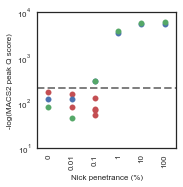

In [56]:
plt.figure(figsize = (2.5, 2.5))

for i in range(6):
    if i == 5:
        plasmidPeaks = loadPeaks(data_dir + 'figS7/temp/neg_peaks.xls', 20)
    else:
        plasmidPeaks = loadPeaks(data_dir + 'figS7/temp/diluted_1e-' + str(i) + '_peaks.xls', 20)
    temp1 = plasmidPeaks[(plasmidPeaks.start < 2422) & (plasmidPeaks.end > 2422)].index
    temp2 = plasmidPeaks[(plasmidPeaks.start < 4924) & (plasmidPeaks.end > 4884)].index
    temp3 = plasmidPeaks.drop([temp1[0], temp2[0]])
    plt.scatter([10 ** -i] * len(temp3), temp3.logQ, c = [red])
    plt.scatter([10 ** -i] * len(temp1), plasmidPeaks.loc[temp1, 'logQ'], c = [blue])
    plt.scatter([10 ** -i] * len(temp2), plasmidPeaks.loc[temp2, 'logQ'], c = [green])
    
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.0000031623, 3.1623])
plt.ylim(10, 10000)
plt.axhline(215, ls = 'dashed', c = 'gray')
plt.xlabel('Nick penetrance (%)')
plt.ylabel('-log(MACS2 peak Q score)')
plt.xticks([10 ** i for i in range(-5, 1)])
plt.gca().set_xticklabels(['0'] + [s.replace('_', '.') for s in files[::-1]], rotation = 'vertical')

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S7D.pdf', bbox_inches = 'tight', transparent = 'True')

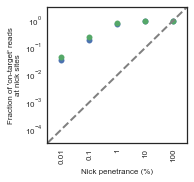

In [57]:
plt.figure(figsize = (2.5, 2.5))

plt.scatter([10 ** -i for i in range(5)], [onCov[i][2423] / (onCov[i][2423] + offCov[i][2423]) for i in range(5)], c = [blue])
plt.scatter([10 ** -i for i in range(5)], [onCov[i][4885] / (onCov[i][4885] + offCov[i][4885]) for i in range(5)], c = [green])
plt.plot([0.000005, 5], [0.000005, 5], ls = 'dashed', c = 'gray')
plt.xlabel('Nick penetrance (%)')
plt.ylabel("Fraction of 'on-target' reads\nat nick sites")
plt.xscale('log')
plt.yscale('log')
plt.ylim([0.000031623, 3.1623])
plt.xlim([0.000031623, 3.1623])
plt.xticks([10 ** i for i in range(-4, 1)])
plt.gca().set_xticklabels([s.replace('_', '.') for s in files[::-1]], rotation = 'vertical')

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S7E.pdf', bbox_inches = 'tight', transparent = 'True')

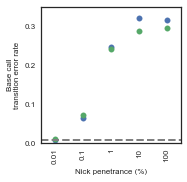

In [58]:
plt.figure(figsize = (2.5, 2.5))

plt.scatter([10 ** -i for i in range(5)], [bases[i][2423][transition[2423]] for i in range(5)], c = [blue])
plt.scatter([10 ** -i for i in range(5)], [bases[i][4885][transition[4885]] for i in range(5)], c = [green])
plt.axhline(max([bases[5][x][transition[x]] for x in range(5, 7300)]), c = 'gray', ls = 'dashed')
plt.xlabel('Nick penetrance (%)')
plt.ylabel('Base call\ntransition error rate')
plt.xscale('log')
plt.xlim([0.000031623, 3.1623])
plt.ylim(0.0001, 0.35)
plt.xticks([10 ** i for i in range(-4, 1)])
plt.gca().set_xticklabels([s.replace('_', '.') for s in files[::-1]], rotation = 'vertical')
plt.yticks([0, 0.1, 0.2, 0.3])

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S7F.pdf', bbox_inches = 'tight', transparent = 'True')

### Figure S8

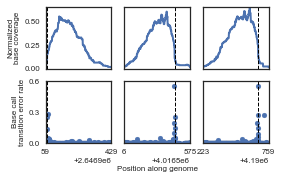

In [59]:
# must run code for fig 5 first

m = max(genomeCov)

plt.figure(figsize = (4, 2.5))
        
count = 0
count2 = 0
for _, peak in peaks[peaks.nicksContained > 0].iterrows():
    if calledNicks[count] in range(peak.start, peak.end):
        if count in [2, 6, 8]:
            plt.subplot(2, 3, count2 + 1)
            plt.xticks([])
            plt.ylim((0, 0.65))
            plt.xlim([peak.start, peak.end])
            plt.plot(range(peak.start, peak.end + 1), genomeCov[peak.start:peak.end + 1] / m)
            if count2 == 0:
                plt.ylabel('Normalized\nbase coverage')
                plt.yticks([0, 0.25, 0.5])
            else:
                plt.yticks([])
            plt.axvline(calledNicks[count], ls = 'dashed', color = 'black', lw = 1)
            if count == 3:
                plt.axvline(calledNicks[count + 1], ls = 'dashed', color = 'black', lw = 1)

            plt.subplot(2, 3, count2 + 4)
            plt.xlim([peak.start, peak.end])
            plt.ylim([0, 0.6])
            plt.xticks([peak.start, peak.end], horizontalalignment = 'center')
            transition = baseTransitions(genomeReference[peak.start:peak.end + 1])
            plt.scatter(range(peak.start, peak.end + 1), [genomeBases[i + peak.start][transition[i]] for i in range(len(transition))], s = 24)
            if count2 == 0:
                plt.ylabel('Base call\ntransition error rate')
                plt.yticks([0, 0.3, 0.6])
                plt.gca().get_xaxis().get_major_formatter().set_useOffset(2646900)
            else:
                plt.yticks([])
                if count2 == 1:
                    plt.xlabel('\nPosition along genome')
                    plt.gca().get_xaxis().get_major_formatter().set_useOffset(4016500)
            plt.axvline(calledNicks[count], ls = 'dashed', color = 'black', lw = 1)
            if count == 3:
                plt.axvline(calledNicks[count + 1], ls = 'dashed', color = 'black', lw = 1)
            count2 += 1

        count += 1
        if count == 1 or count == 4:
            count += 1
            
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S8A.pdf', bbox_inches = 'tight', transparent = 'True')

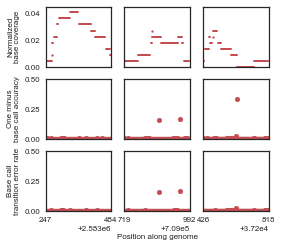

In [60]:
m = max(genomeCov)
badPeaks = peaks.loc[[1734, 501, 27]]

plt.figure(figsize = (4, 3.75))
        
count = 0
count2 = 0
for _, peak in badPeaks.iterrows():
    plt.subplot(3, 3, count2 + 1)
    plt.xticks([])
    plt.ylim((0, 0.045))
    plt.xlim(peak.start, peak.end + 1)
    toPlot = genomeCov[peak.start:peak.end + 1] / m
    jumps = np.where(toPlot[1:] != toPlot[:-1])[0]
    plt.plot([peak.start, peak.start + jumps[0]], [toPlot[0], toPlot[jumps[0]]], c = red)
    for i in range(1, len(jumps)):
        plt.plot([peak.start + jumps[i - 1] + 1, peak.start + jumps[i]], [toPlot[jumps[i - 1] + 1], toPlot[jumps[i]]], c = red)
        if jumps[i - 1] + 1 == jumps[i]:
            plt.scatter(peak.start + jumps[i], toPlot[jumps[i]], s = 4, c = [red])
    if count2 == 0:
        plt.ylabel('Normalized\nbase coverage')
        plt.yticks([0, 0.02, 0.04])
    else:
        plt.yticks([])

    plt.subplot(3, 3, count2 + 4)
    plt.xlim([peak.start, peak.end + 1])
    plt.ylim([0, 0.5])
    acc = [1 - genomeBases[i][genomeReference[i]] for i in range(peak.start, peak.end + 1)]
    plt.scatter(range(peak.start, peak.end + 1), np.nan_to_num(acc), s = 24, c = [red])
    plt.xticks([])
    if count2 == 0:
        plt.ylabel('One minus\nbase call accuracy')
        plt.yticks([0, 0.25, 0.5])
    else:
        plt.yticks([])
            
    plt.subplot(3, 3, count2 + 7)
    transition = baseTransitions(genomeReference[peak.start:peak.end + 1])
    pkSignal2 = [genomeBases[peak.start + i][transition[i]] for i in range(len(transition))]
    plt.scatter(range(peak.start, peak.end + 1), np.nan_to_num(pkSignal2), s = 24, c = [red])
    plt.xlim([peak.start, peak.end + 1])
    plt.ylim([0, 0.5])
    plt.xticks([peak.start, peak.end], horizontalalignment = 'center')
    if count2 == 0:
        plt.ylabel('Base call\ntransition error rate')
        plt.yticks([0, 0.25, 0.5])
    else:
        plt.yticks([])
        if count2 == 1:
            plt.xlabel('\nPosition along genome')
            plt.gca().get_xaxis().get_major_formatter().set_useOffset(709000)
        else:
            plt.gca().get_xaxis().get_major_formatter().set_useOffset(37200)
            
    count2 += 1
    
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S8B.pdf', bbox_inches = 'tight', transparent = 'True')